In [3]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import pandas as pd
import numpy as np
import os

## Load data

In [11]:
data = pd.read_pickle('../data/data_proton_photonsum_15.pkl')
print('Loaded: ',  data.shape)
data_cond = pd.read_pickle('../data/data_cond_photonsum_15.pkl')
print('Loaded cond: ',  data_cond.shape)

Loaded:  (15611, 56, 30)
Loaded cond:  (15611, 12)


In [13]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [14]:
data_cond.head()

,Pdg,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,2112,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0
1,2212,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
2,310,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
3,2212,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
4,2112,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0


### Preprocess data

In [15]:
data = np.float32(np.log(data+1))

In [17]:
# Credits: majerzemilia

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


In [18]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")
NAME = "model_"+DATE_STR
print(DATE_STR, NAME)

26_02_2023_17_15 model_26_02_2023_17_15


In [19]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)
    with open(f"../models/{out_fnm}", mode="w") as f:
        f.write(res)

In [27]:
#train/test split
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#scale cond data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

(12488, 56, 30) (3123, 56, 30) (12488, 10) (3123, 10)
cond max 32.02692928725638 min -57.71366111779493


In [31]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 10
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond,x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_8[0][0]']               
                                                                                            

In [35]:
#trainin params

EPOCHS = 500
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[:num_examples_to_generate]


### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

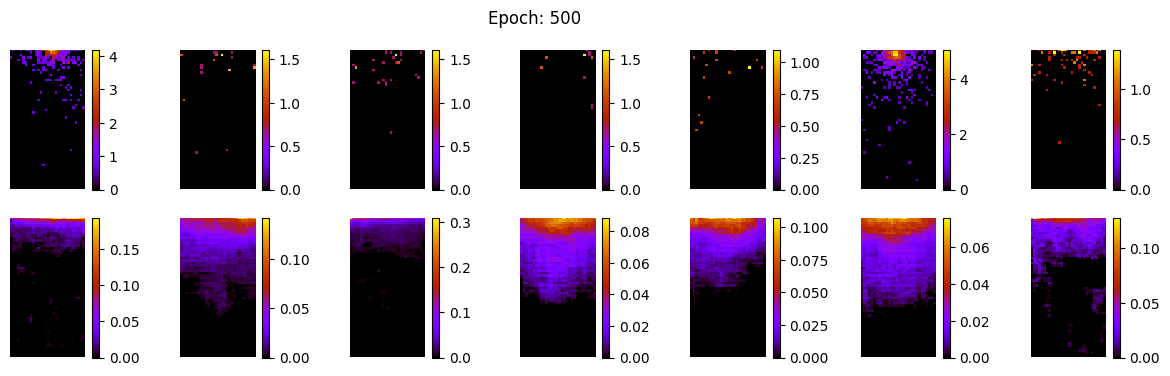

98/98 [==============================] - 0s 3ms/step
ws mean 25.07 ch1 22.04 ch2 38.91 ch3 0.71 ch4 0.75 ch5 62.96 Time for epoch 1 is 5.880391836166382 sec
100 [Total loss: 34.44] [Recon_loss: 34.04] [KL loss: 0.58]
98/98 [==============================] - 0s 3ms/step
ws mean 23.20 ch1 19.89 ch2 36.24 ch3 0.75 ch4 0.76 ch5 58.35 Time for epoch 2 is 4.6041998863220215 sec
200 [Total loss: 39.59] [Recon_loss: 39.25] [KL loss: 0.48]
98/98 [==============================] - 0s 3ms/step
ws mean 24.20 ch1 21.36 ch2 37.06 ch3 0.82 ch4 0.83 ch5 60.94 Time for epoch 3 is 4.615586996078491 sec
300 [Total loss: 34.17] [Recon_loss: 33.71] [KL loss: 0.65]
98/98 [==============================] - 0s 3ms/step
ws mean 24.48 ch1 20.86 ch2 38.32 ch3 0.83 ch4 0.85 ch5 61.54 Time for epoch 4 is 4.6331048011779785 sec
400 [Total loss: 32.66] [Recon_loss: 32.42] [KL loss: 0.34]
98/98 [==============================] - 0s 3ms/step
ws mean 26.11 ch1 22.36 ch2 40.66 ch3 0.86 ch4 0.86 ch5 65.83 Time for epoch 

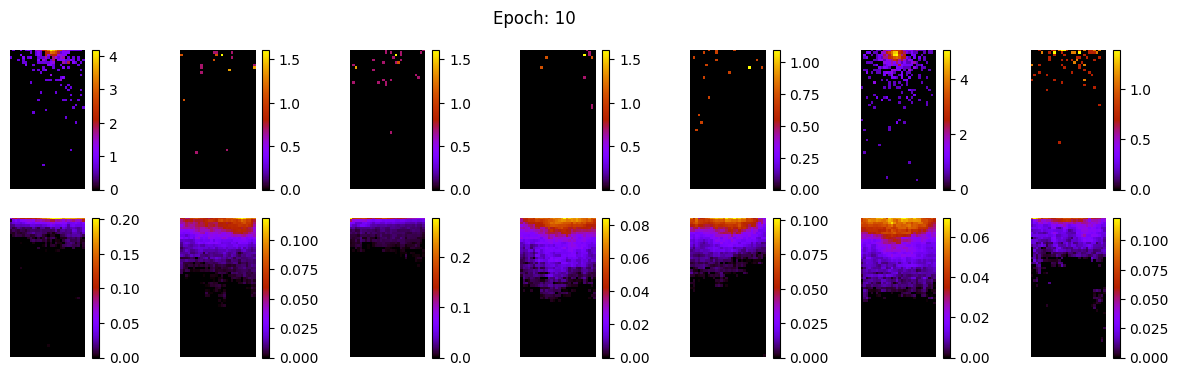

98/98 [==============================] - 0s 3ms/step
ws mean 24.84 ch1 22.33 ch2 37.39 ch3 0.88 ch4 0.89 ch5 62.69 Time for epoch 11 is 7.360007286071777 sec
1100 [Total loss: 36.61] [Recon_loss: 36.32] [KL loss: 0.41]
98/98 [==============================] - 0s 3ms/step
ws mean 25.30 ch1 22.18 ch2 38.99 ch3 0.75 ch4 0.79 ch5 63.81 Time for epoch 12 is 5.768032789230347 sec
1200 [Total loss: 34.08] [Recon_loss: 33.76] [KL loss: 0.45]
98/98 [==============================] - 0s 3ms/step
ws mean 26.95 ch1 23.43 ch2 41.21 ch3 1.02 ch4 1.02 ch5 68.06 Time for epoch 13 is 5.782605886459351 sec
1300 [Total loss: 36.86] [Recon_loss: 36.58] [KL loss: 0.40]
98/98 [==============================] - 0s 3ms/step
ws mean 24.82 ch1 22.08 ch2 37.91 ch3 0.80 ch4 0.82 ch5 62.49 Time for epoch 14 is 5.778064727783203 sec
1400 [Total loss: 38.23] [Recon_loss: 37.82] [KL loss: 0.58]
98/98 [==============================] - 0s 3ms/step
ws mean 19.91 ch1 18.11 ch2 30.48 ch3 0.71 ch4 0.73 ch5 49.53 Time for 

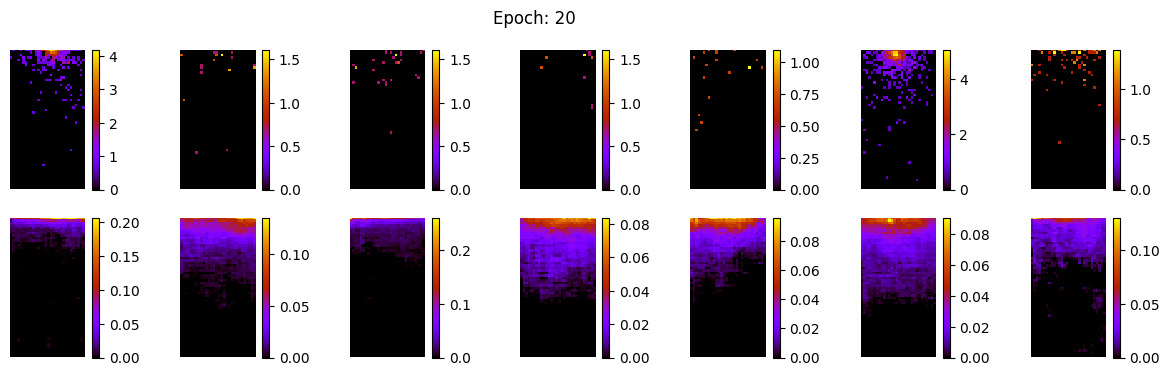

98/98 [==============================] - 0s 3ms/step
ws mean 28.06 ch1 24.36 ch2 43.35 ch3 0.84 ch4 0.88 ch5 70.89 Time for epoch 21 is 8.229262590408325 sec
2100 [Total loss: 39.54] [Recon_loss: 39.22] [KL loss: 0.47]
98/98 [==============================] - 0s 3ms/step
ws mean 25.26 ch1 22.55 ch2 38.19 ch3 0.84 ch4 0.87 ch5 63.83 Time for epoch 22 is 6.975827932357788 sec
2200 [Total loss: 41.63] [Recon_loss: 41.15] [KL loss: 0.69]
98/98 [==============================] - 0s 3ms/step
ws mean 27.31 ch1 23.27 ch2 42.56 ch3 0.89 ch4 0.89 ch5 68.91 Time for epoch 23 is 6.966363191604614 sec
2300 [Total loss: 37.05] [Recon_loss: 36.78] [KL loss: 0.38]
98/98 [==============================] - 0s 3ms/step
ws mean 20.46 ch1 19.36 ch2 30.06 ch3 0.83 ch4 0.86 ch5 51.17 Time for epoch 24 is 6.98081111907959 sec
2400 [Total loss: 37.66] [Recon_loss: 37.33] [KL loss: 0.47]
98/98 [==============================] - 0s 3ms/step
ws mean 25.99 ch1 22.81 ch2 39.85 ch3 0.82 ch4 0.85 ch5 65.61 Time for e

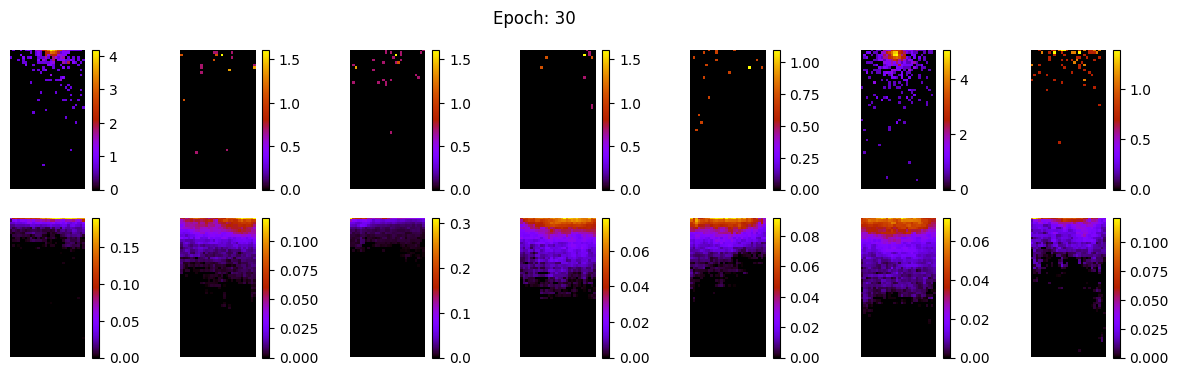

98/98 [==============================] - 0s 3ms/step
ws mean 23.98 ch1 21.53 ch2 36.58 ch3 0.91 ch4 0.94 ch5 59.95 Time for epoch 31 is 8.680984258651733 sec
3100 [Total loss: 36.91] [Recon_loss: 36.60] [KL loss: 0.44]
98/98 [==============================] - 0s 3ms/step
ws mean 22.77 ch1 20.59 ch2 34.69 ch3 0.79 ch4 0.81 ch5 56.96 Time for epoch 32 is 7.085899353027344 sec
3200 [Total loss: 36.65] [Recon_loss: 36.25] [KL loss: 0.56]
98/98 [==============================] - 0s 3ms/step
ws mean 17.65 ch1 17.51 ch2 25.63 ch3 0.71 ch4 0.74 ch5 43.66 Time for epoch 33 is 7.091061592102051 sec
3300 [Total loss: 37.26] [Recon_loss: 36.78] [KL loss: 0.68]
98/98 [==============================] - 0s 3ms/step
ws mean 23.06 ch1 20.32 ch2 35.51 ch3 0.78 ch4 0.80 ch5 57.89 Time for epoch 34 is 7.102227449417114 sec
3400 [Total loss: 36.74] [Recon_loss: 36.50] [KL loss: 0.34]
98/98 [==============================] - 0s 3ms/step
ws mean 24.99 ch1 21.79 ch2 39.25 ch3 0.77 ch4 0.77 ch5 62.36 Time for 

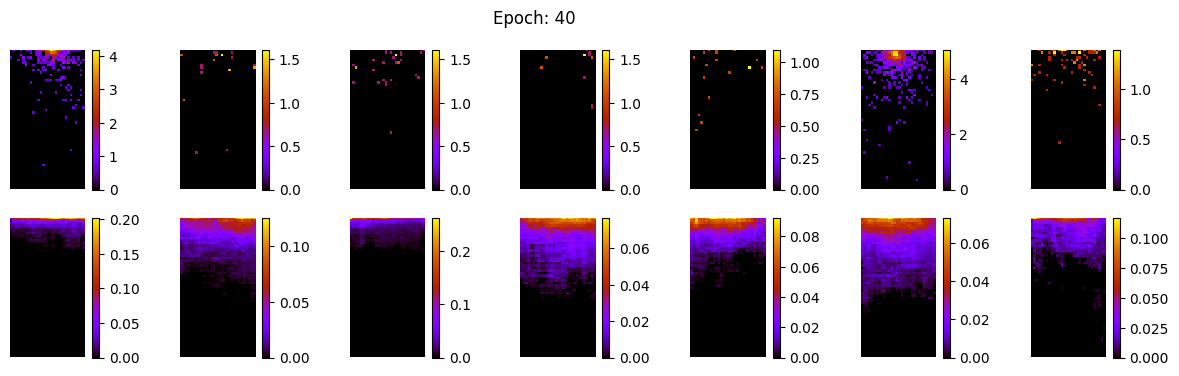

98/98 [==============================] - 0s 4ms/step
ws mean 19.25 ch1 16.43 ch2 30.18 ch3 0.80 ch4 0.83 ch5 48.01 Time for epoch 41 is 8.389384746551514 sec
4100 [Total loss: 38.91] [Recon_loss: 38.26] [KL loss: 0.93]
98/98 [==============================] - 0s 4ms/step
ws mean 22.51 ch1 19.70 ch2 34.88 ch3 0.81 ch4 0.84 ch5 56.33 Time for epoch 42 is 7.162154197692871 sec
4200 [Total loss: 33.90] [Recon_loss: 33.65] [KL loss: 0.36]
98/98 [==============================] - 0s 4ms/step
ws mean 23.46 ch1 20.81 ch2 35.78 ch3 0.83 ch4 0.86 ch5 59.02 Time for epoch 43 is 7.432209014892578 sec
4300 [Total loss: 39.04] [Recon_loss: 38.71] [KL loss: 0.48]
98/98 [==============================] - 0s 4ms/step
ws mean 22.69 ch1 20.15 ch2 34.71 ch3 0.86 ch4 0.89 ch5 56.84 Time for epoch 44 is 7.1949989795684814 sec
4400 [Total loss: 32.20] [Recon_loss: 32.00] [KL loss: 0.30]
98/98 [==============================] - 0s 4ms/step
ws mean 25.68 ch1 22.90 ch2 39.11 ch3 0.95 ch4 0.97 ch5 64.46 Time for

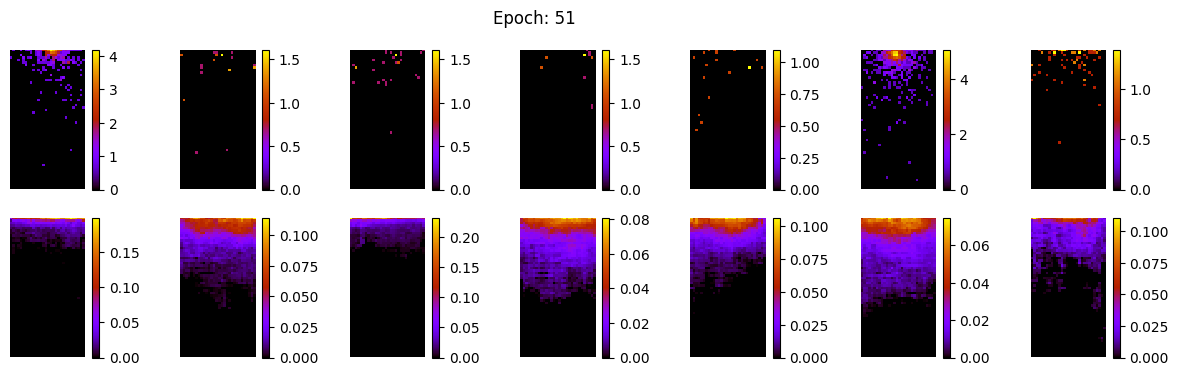

98/98 [==============================] - 0s 4ms/step
ws mean 21.65 ch1 19.75 ch2 32.95 ch3 0.77 ch4 0.80 ch5 53.98 Time for epoch 52 is 8.543927192687988 sec
5100 [Total loss: 35.63] [Recon_loss: 35.33] [KL loss: 0.43]
98/98 [==============================] - 0s 4ms/step
ws mean 22.65 ch1 20.24 ch2 34.99 ch3 0.75 ch4 0.77 ch5 56.53 Time for epoch 53 is 7.22410774230957 sec
5200 [Total loss: 32.95] [Recon_loss: 32.80] [KL loss: 0.22]
98/98 [==============================] - 0s 4ms/step
ws mean 21.41 ch1 19.60 ch2 32.57 ch3 0.73 ch4 0.76 ch5 53.40 Time for epoch 54 is 7.234819650650024 sec
5300 [Total loss: 28.30] [Recon_loss: 28.16] [KL loss: 0.20]
98/98 [==============================] - 0s 4ms/step
ws mean 26.05 ch1 22.55 ch2 40.00 ch3 0.93 ch4 0.97 ch5 65.80 Time for epoch 55 is 7.210927248001099 sec
5400 [Total loss: 35.92] [Recon_loss: 35.67] [KL loss: 0.37]
98/98 [==============================] - 0s 4ms/step
ws mean 25.69 ch1 21.96 ch2 40.11 ch3 0.84 ch4 0.83 ch5 64.71 Time for e

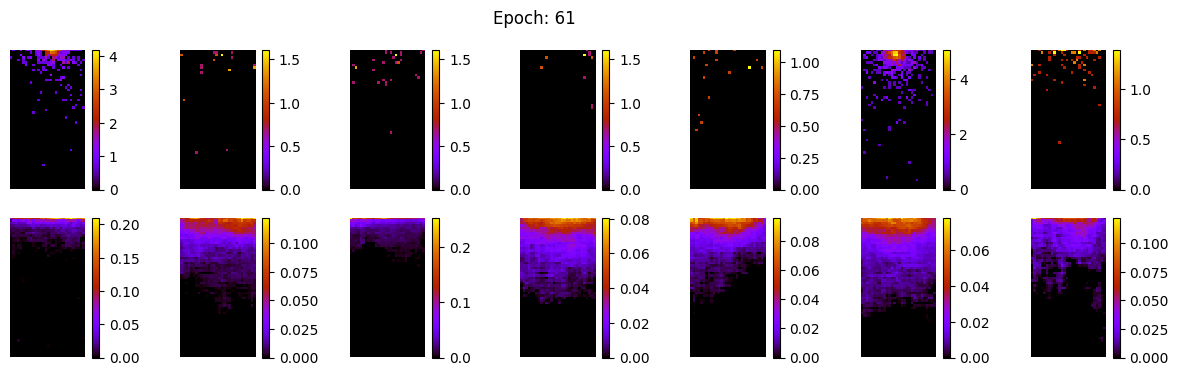

98/98 [==============================] - 0s 4ms/step
ws mean 22.87 ch1 19.97 ch2 35.15 ch3 0.89 ch4 0.92 ch5 57.44 Time for epoch 62 is 8.762311697006226 sec
6100 [Total loss: 42.22] [Recon_loss: 41.48] [KL loss: 1.05]
98/98 [==============================] - 0s 4ms/step
ws mean 21.99 ch1 20.25 ch2 32.92 ch3 0.91 ch4 0.91 ch5 54.99 Time for epoch 63 is 7.190395832061768 sec
6200 [Total loss: 33.87] [Recon_loss: 33.66] [KL loss: 0.29]
98/98 [==============================] - 0s 4ms/step
ws mean 20.38 ch1 18.77 ch2 30.64 ch3 0.82 ch4 0.85 ch5 50.82 Time for epoch 64 is 7.187412738800049 sec
6300 [Total loss: 31.38] [Recon_loss: 31.10] [KL loss: 0.41]
98/98 [==============================] - 0s 4ms/step
ws mean 21.66 ch1 19.09 ch2 33.55 ch3 0.76 ch4 0.78 ch5 54.14 Time for epoch 65 is 7.1531453132629395 sec
6400 [Total loss: 37.14] [Recon_loss: 36.82] [KL loss: 0.46]
98/98 [==============================] - 0s 4ms/step
ws mean 21.67 ch1 19.00 ch2 33.71 ch3 0.82 ch4 0.82 ch5 54.01 Time for

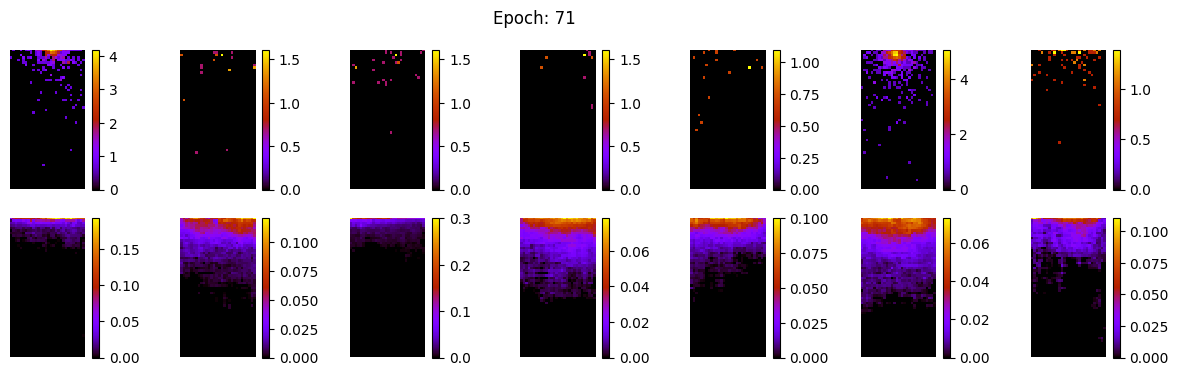

98/98 [==============================] - 0s 3ms/step
ws mean 20.14 ch1 18.16 ch2 30.62 ch3 0.76 ch4 0.79 ch5 50.35 Time for epoch 72 is 8.409247875213623 sec
7100 [Total loss: 35.89] [Recon_loss: 35.64] [KL loss: 0.34]
98/98 [==============================] - 0s 3ms/step
ws mean 17.81 ch1 17.48 ch2 26.28 ch3 0.72 ch4 0.72 ch5 43.85 Time for epoch 73 is 7.121816158294678 sec
7200 [Total loss: 36.43] [Recon_loss: 36.16] [KL loss: 0.39]
98/98 [==============================] - 0s 4ms/step
ws mean 24.17 ch1 21.04 ch2 37.40 ch3 0.83 ch4 0.82 ch5 60.77 Time for epoch 74 is 7.110458850860596 sec
7300 [Total loss: 32.22] [Recon_loss: 32.01] [KL loss: 0.30]
98/98 [==============================] - 0s 3ms/step
ws mean 23.93 ch1 20.90 ch2 36.84 ch3 0.79 ch4 0.81 ch5 60.30 Time for epoch 75 is 7.10906982421875 sec
7400 [Total loss: 37.56] [Recon_loss: 37.24] [KL loss: 0.46]
98/98 [==============================] - 0s 4ms/step
ws mean 19.00 ch1 18.06 ch2 28.07 ch3 0.83 ch4 0.85 ch5 47.19 Time for e

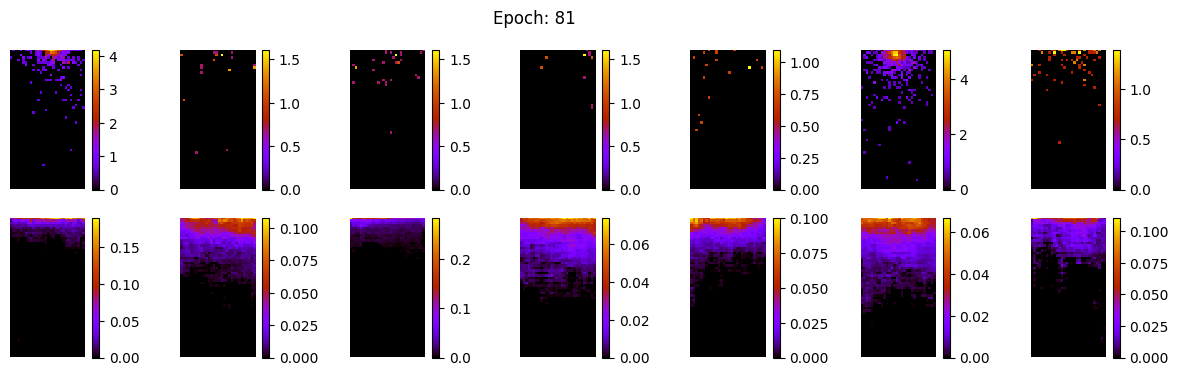

98/98 [==============================] - 0s 4ms/step
ws mean 18.31 ch1 16.91 ch2 27.87 ch3 0.73 ch4 0.75 ch5 45.30 Time for epoch 82 is 8.44450330734253 sec
8100 [Total loss: 33.05] [Recon_loss: 32.86] [KL loss: 0.28]
98/98 [==============================] - 0s 4ms/step
ws mean 26.19 ch1 22.63 ch2 40.29 ch3 0.95 ch4 0.97 ch5 66.12 Time for epoch 83 is 7.187287330627441 sec
8200 [Total loss: 29.60] [Recon_loss: 29.42] [KL loss: 0.25]
98/98 [==============================] - 0s 4ms/step
ws mean 21.94 ch1 20.22 ch2 32.77 ch3 0.88 ch4 0.91 ch5 54.92 Time for epoch 84 is 7.205487966537476 sec
8300 [Total loss: 36.34] [Recon_loss: 36.03] [KL loss: 0.44]
98/98 [==============================] - 0s 4ms/step
ws mean 21.13 ch1 19.49 ch2 31.73 ch3 0.83 ch4 0.87 ch5 52.74 Time for epoch 85 is 7.186429500579834 sec
8400 [Total loss: 34.29] [Recon_loss: 34.05] [KL loss: 0.35]
98/98 [==============================] - 0s 4ms/step
ws mean 23.36 ch1 20.84 ch2 35.59 ch3 0.86 ch4 0.88 ch5 58.65 Time for e

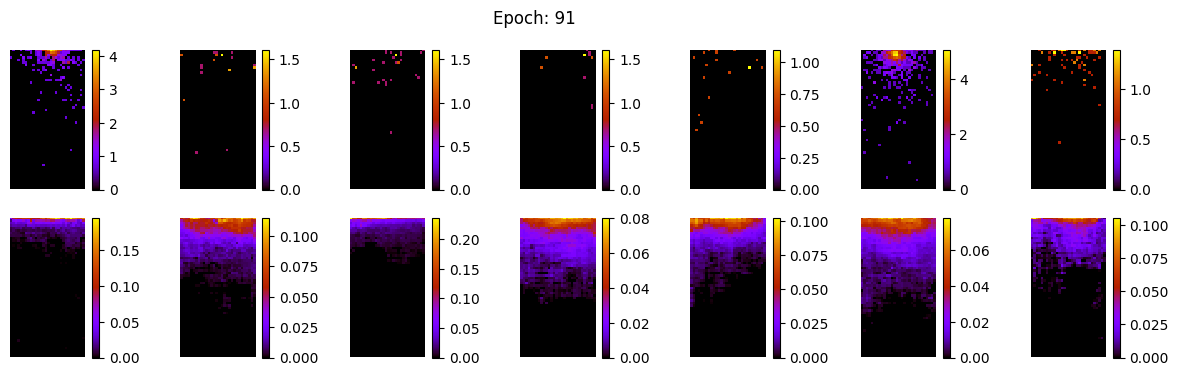

98/98 [==============================] - 0s 4ms/step
ws mean 21.21 ch1 19.27 ch2 31.84 ch3 0.81 ch4 0.85 ch5 53.28 Time for epoch 92 is 8.470162391662598 sec
9100 [Total loss: 36.92] [Recon_loss: 36.68] [KL loss: 0.35]
98/98 [==============================] - 0s 4ms/step
ws mean 14.23 ch1 14.28 ch2 21.14 ch3 0.76 ch4 0.76 ch5 34.22 Time for epoch 93 is 7.163012266159058 sec
9200 [Total loss: 36.36] [Recon_loss: 36.13] [KL loss: 0.33]
98/98 [==============================] - 0s 4ms/step
ws mean 16.63 ch1 15.94 ch2 24.48 ch3 0.73 ch4 0.74 ch5 41.28 Time for epoch 94 is 7.166073560714722 sec
9300 [Total loss: 30.73] [Recon_loss: 30.54] [KL loss: 0.28]
98/98 [==============================] - 0s 4ms/step
ws mean 19.33 ch1 17.40 ch2 29.38 ch3 0.77 ch4 0.79 ch5 48.30 Time for epoch 95 is 7.157482862472534 sec
9400 [Total loss: 38.32] [Recon_loss: 38.05] [KL loss: 0.38]
98/98 [==============================] - 0s 4ms/step
ws mean 20.63 ch1 18.42 ch2 31.63 ch3 0.83 ch4 0.84 ch5 51.42 Time for 

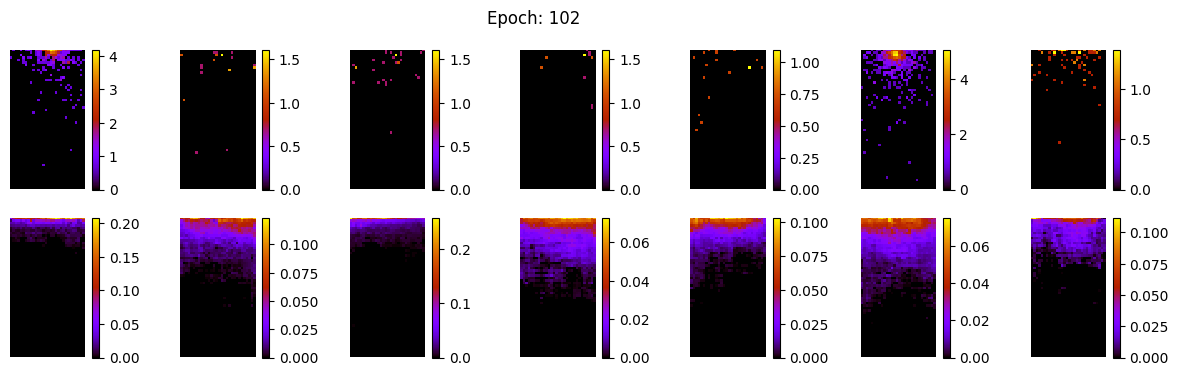

98/98 [==============================] - 0s 3ms/step
ws mean 19.72 ch1 17.76 ch2 30.20 ch3 0.80 ch4 0.81 ch5 49.01 Time for epoch 103 is 8.71552586555481 sec
10100 [Total loss: 38.23] [Recon_loss: 37.99] [KL loss: 0.34]
98/98 [==============================] - 0s 4ms/step
ws mean 21.38 ch1 19.16 ch2 32.44 ch3 0.87 ch4 0.88 ch5 53.56 Time for epoch 104 is 7.1403913497924805 sec
10200 [Total loss: 44.25] [Recon_loss: 43.39] [KL loss: 1.23]
98/98 [==============================] - 0s 3ms/step
ws mean 21.03 ch1 19.21 ch2 31.76 ch3 0.88 ch4 0.89 ch5 52.42 Time for epoch 105 is 7.1358418464660645 sec
10300 [Total loss: 36.23] [Recon_loss: 35.88] [KL loss: 0.49]
98/98 [==============================] - 0s 4ms/step
ws mean 23.51 ch1 20.86 ch2 35.38 ch3 1.00 ch4 1.01 ch5 59.31 Time for epoch 106 is 7.150311470031738 sec
10400 [Total loss: 30.70] [Recon_loss: 30.56] [KL loss: 0.20]
98/98 [==============================] - 0s 4ms/step
ws mean 21.20 ch1 19.23 ch2 32.13 ch3 0.81 ch4 0.82 ch5 52.99 

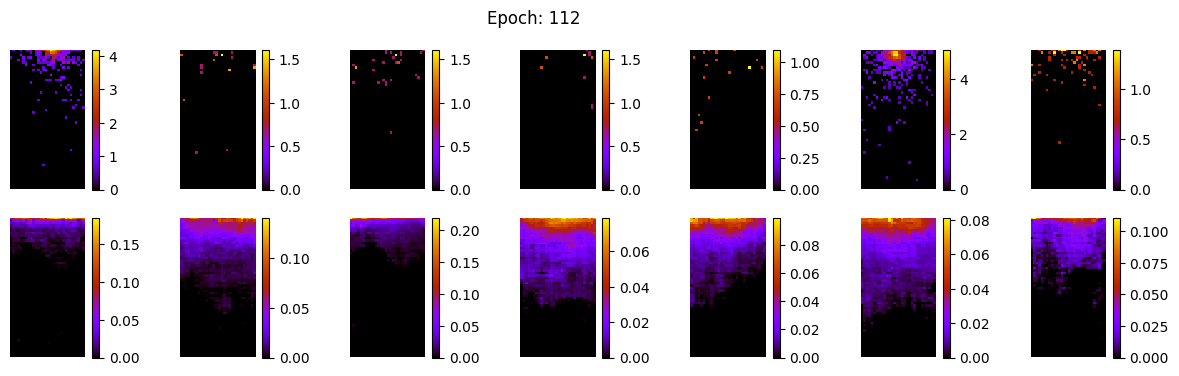

98/98 [==============================] - 0s 4ms/step
ws mean 18.28 ch1 17.23 ch2 27.53 ch3 0.73 ch4 0.77 ch5 45.12 Time for epoch 113 is 8.522546291351318 sec
11100 [Total loss: 44.95] [Recon_loss: 44.10] [KL loss: 1.20]
98/98 [==============================] - 0s 4ms/step
ws mean 20.94 ch1 18.87 ch2 32.17 ch3 0.73 ch4 0.74 ch5 52.17 Time for epoch 114 is 7.195801258087158 sec
11200 [Total loss: 34.12] [Recon_loss: 33.80] [KL loss: 0.46]
98/98 [==============================] - 0s 4ms/step
ws mean 18.54 ch1 17.26 ch2 27.74 ch3 0.80 ch4 0.83 ch5 46.08 Time for epoch 115 is 7.184068202972412 sec
11300 [Total loss: 35.92] [Recon_loss: 35.66] [KL loss: 0.37]
98/98 [==============================] - 0s 4ms/step
ws mean 20.81 ch1 18.70 ch2 31.71 ch3 0.83 ch4 0.83 ch5 51.99 Time for epoch 116 is 7.191979646682739 sec
11400 [Total loss: 33.29] [Recon_loss: 33.06] [KL loss: 0.33]
98/98 [==============================] - 0s 4ms/step
ws mean 20.34 ch1 18.53 ch2 31.08 ch3 0.80 ch4 0.79 ch5 50.51 T

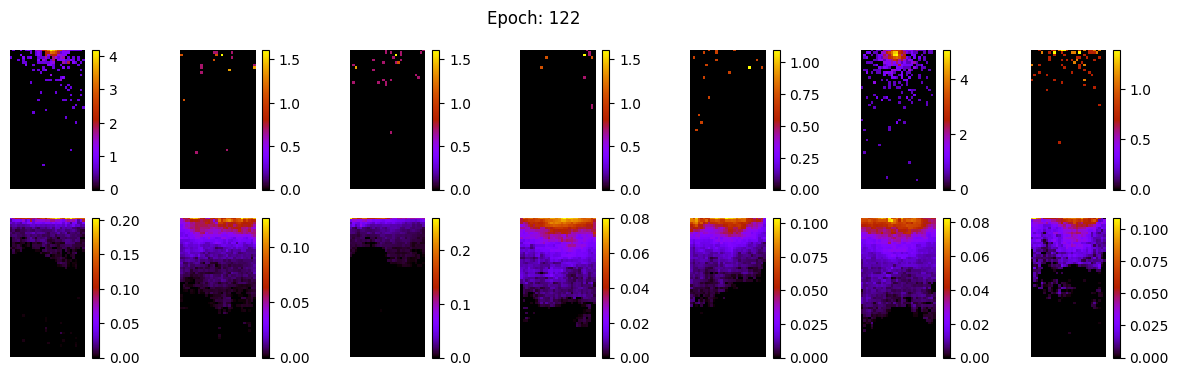

98/98 [==============================] - 0s 4ms/step
ws mean 18.57 ch1 17.50 ch2 27.58 ch3 0.73 ch4 0.76 ch5 46.31 Time for epoch 123 is 8.750216245651245 sec
12100 [Total loss: 34.67] [Recon_loss: 34.42] [KL loss: 0.36]
98/98 [==============================] - 0s 4ms/step
ws mean 19.11 ch1 17.65 ch2 28.54 ch3 0.81 ch4 0.84 ch5 47.71 Time for epoch 124 is 7.160709619522095 sec
12200 [Total loss: 40.96] [Recon_loss: 40.03] [KL loss: 1.34]
98/98 [==============================] - 0s 4ms/step
ws mean 19.42 ch1 17.88 ch2 29.11 ch3 0.76 ch4 0.79 ch5 48.56 Time for epoch 125 is 7.154113292694092 sec
12300 [Total loss: 33.04] [Recon_loss: 32.84] [KL loss: 0.29]
98/98 [==============================] - 0s 4ms/step
ws mean 22.19 ch1 20.23 ch2 33.29 ch3 0.91 ch4 0.92 ch5 55.60 Time for epoch 126 is 7.158710241317749 sec
12400 [Total loss: 35.32] [Recon_loss: 35.11] [KL loss: 0.30]
98/98 [==============================] - 0s 4ms/step
ws mean 17.22 ch1 16.77 ch2 25.18 ch3 0.72 ch4 0.72 ch5 42.71 T

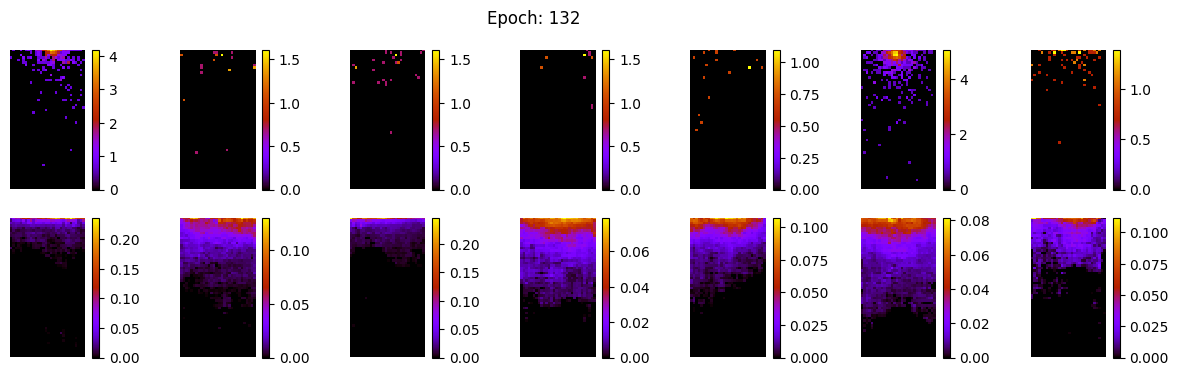

98/98 [==============================] - 0s 3ms/step
ws mean 20.03 ch1 18.60 ch2 30.04 ch3 0.76 ch4 0.78 ch5 49.95 Time for epoch 133 is 8.64048457145691 sec
13100 [Total loss: 36.46] [Recon_loss: 36.16] [KL loss: 0.42]
98/98 [==============================] - 0s 3ms/step
ws mean 19.24 ch1 17.13 ch2 29.60 ch3 0.77 ch4 0.81 ch5 47.89 Time for epoch 134 is 7.146219968795776 sec
13200 [Total loss: 38.11] [Recon_loss: 37.79] [KL loss: 0.46]
98/98 [==============================] - 0s 3ms/step
ws mean 19.77 ch1 17.81 ch2 30.23 ch3 0.80 ch4 0.82 ch5 49.19 Time for epoch 135 is 7.120582103729248 sec
13300 [Total loss: 34.87] [Recon_loss: 34.64] [KL loss: 0.33]
98/98 [==============================] - 0s 4ms/step
ws mean 22.01 ch1 19.10 ch2 33.95 ch3 0.85 ch4 0.88 ch5 55.27 Time for epoch 136 is 7.126703500747681 sec
13400 [Total loss: 33.35] [Recon_loss: 33.01] [KL loss: 0.48]
98/98 [==============================] - 0s 3ms/step
ws mean 20.35 ch1 18.11 ch2 31.11 ch3 0.86 ch4 0.86 ch5 50.82 Ti

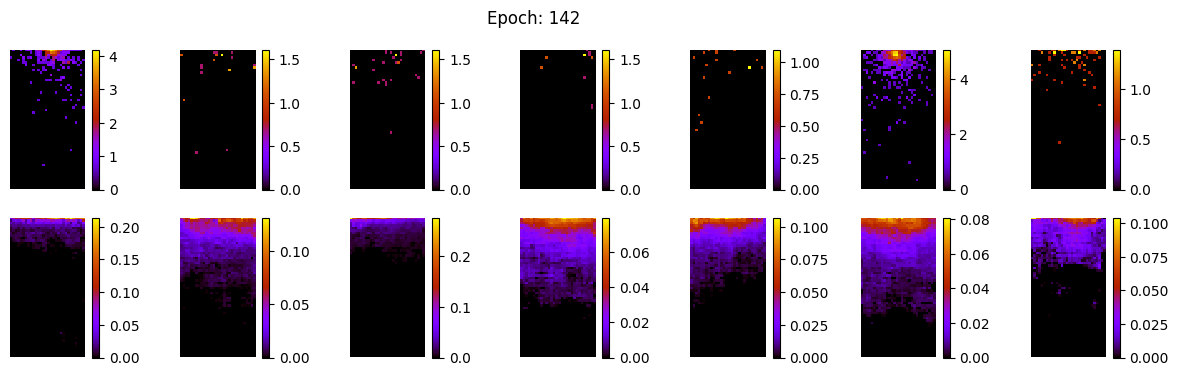

98/98 [==============================] - 0s 4ms/step
ws mean 20.16 ch1 17.95 ch2 31.03 ch3 0.80 ch4 0.78 ch5 50.23 Time for epoch 143 is 8.523123025894165 sec
14100 [Total loss: 37.21] [Recon_loss: 36.90] [KL loss: 0.43]
98/98 [==============================] - 0s 4ms/step
ws mean 19.44 ch1 17.15 ch2 30.05 ch3 0.83 ch4 0.84 ch5 48.35 Time for epoch 144 is 7.214616537094116 sec
14200 [Total loss: 40.04] [Recon_loss: 39.62] [KL loss: 0.61]
98/98 [==============================] - 0s 4ms/step
ws mean 19.57 ch1 18.31 ch2 29.21 ch3 0.82 ch4 0.82 ch5 48.71 Time for epoch 145 is 7.213890075683594 sec
14300 [Total loss: 31.75] [Recon_loss: 31.56] [KL loss: 0.27]
98/98 [==============================] - 0s 4ms/step
ws mean 20.93 ch1 18.88 ch2 31.96 ch3 0.74 ch4 0.76 ch5 52.32 Time for epoch 146 is 7.2095863819122314 sec
14400 [Total loss: 37.70] [Recon_loss: 37.44] [KL loss: 0.37]
98/98 [==============================] - 0s 4ms/step
ws mean 20.34 ch1 18.51 ch2 30.70 ch3 0.82 ch4 0.85 ch5 50.81 

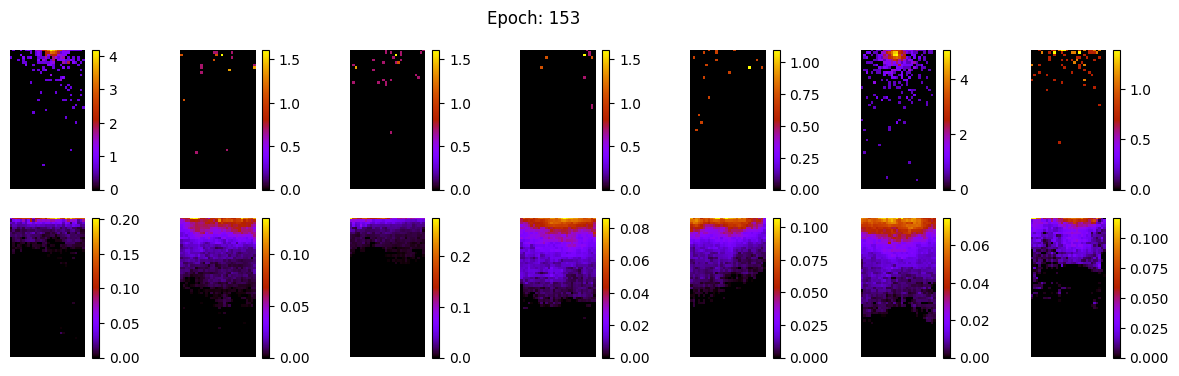

98/98 [==============================] - 0s 4ms/step
ws mean 18.17 ch1 16.85 ch2 27.12 ch3 0.86 ch4 0.88 ch5 45.15 Time for epoch 154 is 8.431338787078857 sec
15100 [Total loss: 32.97] [Recon_loss: 32.72] [KL loss: 0.36]
98/98 [==============================] - 0s 3ms/step
ws mean 22.37 ch1 19.51 ch2 34.18 ch3 0.92 ch4 0.91 ch5 56.34 Time for epoch 155 is 7.123730421066284 sec
15200 [Total loss: 41.95] [Recon_loss: 41.12] [KL loss: 1.18]
98/98 [==============================] - 0s 4ms/step
ws mean 17.68 ch1 16.04 ch2 27.06 ch3 0.76 ch4 0.74 ch5 43.80 Time for epoch 156 is 7.1223413944244385 sec
15300 [Total loss: 31.85] [Recon_loss: 31.67] [KL loss: 0.26]
98/98 [==============================] - 0s 4ms/step
ws mean 20.25 ch1 18.05 ch2 31.02 ch3 0.84 ch4 0.86 ch5 50.50 Time for epoch 157 is 7.133511304855347 sec
15400 [Total loss: 41.47] [Recon_loss: 40.51] [KL loss: 1.36]
98/98 [==============================] - 0s 4ms/step
ws mean 13.57 ch1 13.42 ch2 20.44 ch3 0.67 ch4 0.70 ch5 32.64 

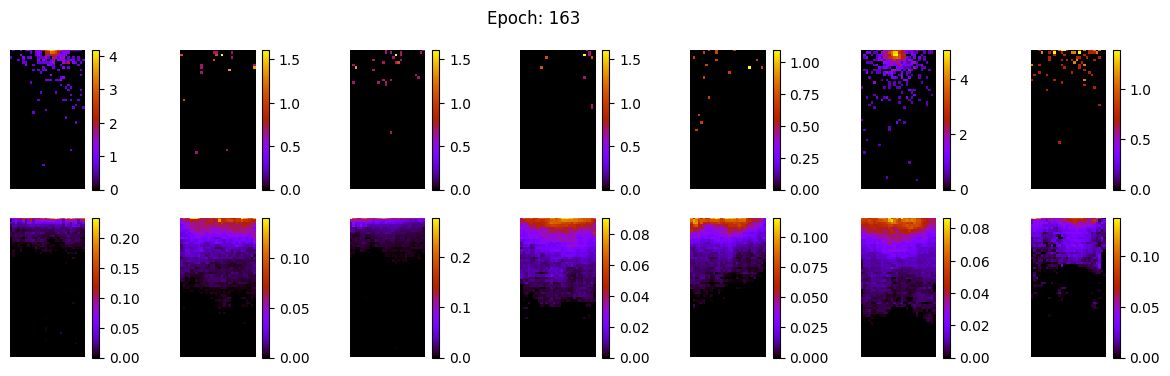

98/98 [==============================] - 0s 4ms/step
ws mean 23.23 ch1 19.83 ch2 36.66 ch3 0.72 ch4 0.72 ch5 58.22 Time for epoch 164 is 8.461888551712036 sec
16100 [Total loss: 34.90] [Recon_loss: 34.70] [KL loss: 0.28]
98/98 [==============================] - 0s 4ms/step
ws mean 21.59 ch1 19.16 ch2 32.84 ch3 0.86 ch4 0.88 ch5 54.22 Time for epoch 165 is 7.17720627784729 sec
16200 [Total loss: 30.70] [Recon_loss: 30.53] [KL loss: 0.24]
98/98 [==============================] - 0s 4ms/step
ws mean 18.15 ch1 16.86 ch2 27.48 ch3 0.70 ch4 0.73 ch5 44.97 Time for epoch 166 is 7.185749053955078 sec
16300 [Total loss: 34.04] [Recon_loss: 33.70] [KL loss: 0.48]
98/98 [==============================] - 0s 4ms/step
ws mean 18.64 ch1 16.83 ch2 28.49 ch3 0.80 ch4 0.82 ch5 46.28 Time for epoch 167 is 7.4638283252716064 sec
16400 [Total loss: 41.80] [Recon_loss: 41.04] [KL loss: 1.09]
98/98 [==============================] - 0s 4ms/step
ws mean 20.12 ch1 18.25 ch2 30.69 ch3 0.77 ch4 0.78 ch5 50.13 T

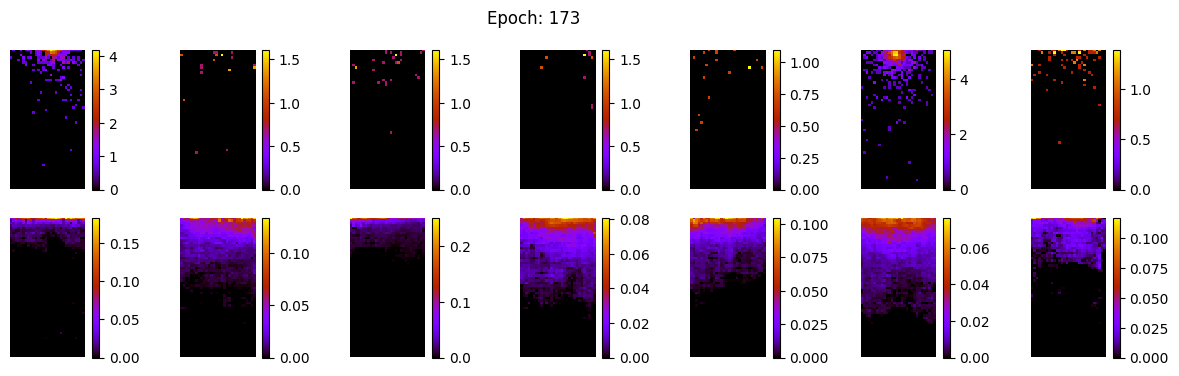

98/98 [==============================] - 0s 3ms/step
ws mean 23.16 ch1 20.48 ch2 34.92 ch3 1.01 ch4 1.02 ch5 58.36 Time for epoch 174 is 8.435831785202026 sec
17100 [Total loss: 35.00] [Recon_loss: 34.80] [KL loss: 0.30]
98/98 [==============================] - 0s 4ms/step
ws mean 21.67 ch1 19.49 ch2 33.04 ch3 0.77 ch4 0.79 ch5 54.25 Time for epoch 175 is 7.1199681758880615 sec
17200 [Total loss: 32.46] [Recon_loss: 32.25] [KL loss: 0.30]
98/98 [==============================] - 0s 3ms/step
ws mean 21.93 ch1 19.80 ch2 33.13 ch3 0.91 ch4 0.92 ch5 54.88 Time for epoch 176 is 7.131641626358032 sec
17300 [Total loss: 31.67] [Recon_loss: 31.45] [KL loss: 0.31]
98/98 [==============================] - 0s 4ms/step
ws mean 18.43 ch1 16.95 ch2 27.97 ch3 0.78 ch4 0.77 ch5 45.68 Time for epoch 177 is 7.1360814571380615 sec
17400 [Total loss: 37.08] [Recon_loss: 36.75] [KL loss: 0.47]
98/98 [==============================] - 0s 3ms/step
ws mean 20.73 ch1 18.51 ch2 31.58 ch3 0.82 ch4 0.84 ch5 51.90

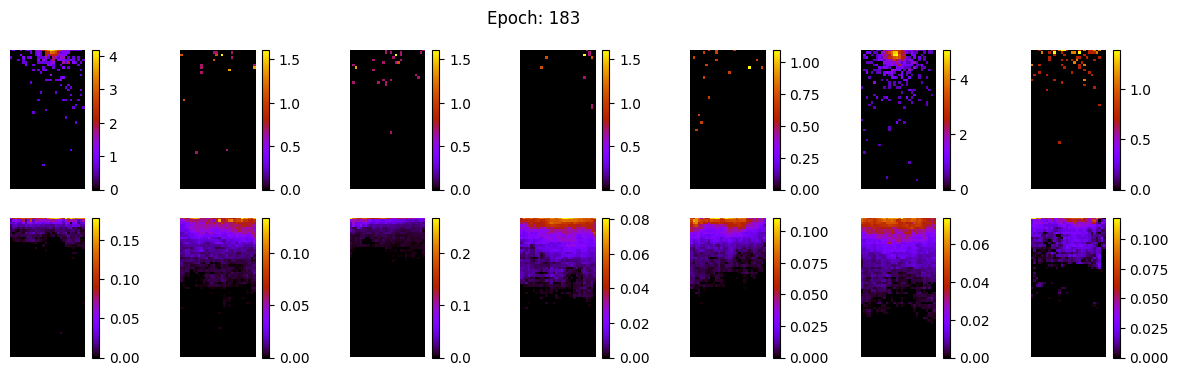

98/98 [==============================] - 0s 4ms/step
ws mean 17.97 ch1 16.51 ch2 27.00 ch3 0.77 ch4 0.77 ch5 44.77 Time for epoch 184 is 8.457533121109009 sec
18100 [Total loss: 31.72] [Recon_loss: 31.51] [KL loss: 0.31]
98/98 [==============================] - 0s 3ms/step
ws mean 17.81 ch1 15.99 ch2 27.16 ch3 0.80 ch4 0.80 ch5 44.30 Time for epoch 185 is 7.033991575241089 sec
18200 [Total loss: 36.28] [Recon_loss: 36.01] [KL loss: 0.38]
98/98 [==============================] - 0s 3ms/step
ws mean 19.55 ch1 17.93 ch2 29.28 ch3 0.89 ch4 0.90 ch5 48.75 Time for epoch 186 is 7.234352350234985 sec
18300 [Total loss: 41.29] [Recon_loss: 40.38] [KL loss: 1.31]
98/98 [==============================] - 0s 3ms/step
ws mean 20.95 ch1 18.69 ch2 31.93 ch3 0.81 ch4 0.80 ch5 52.52 Time for epoch 187 is 6.944441556930542 sec
18400 [Total loss: 36.13] [Recon_loss: 35.78] [KL loss: 0.49]
98/98 [==============================] - 0s 3ms/step
ws mean 18.43 ch1 16.98 ch2 27.85 ch3 0.76 ch4 0.77 ch5 45.80 T

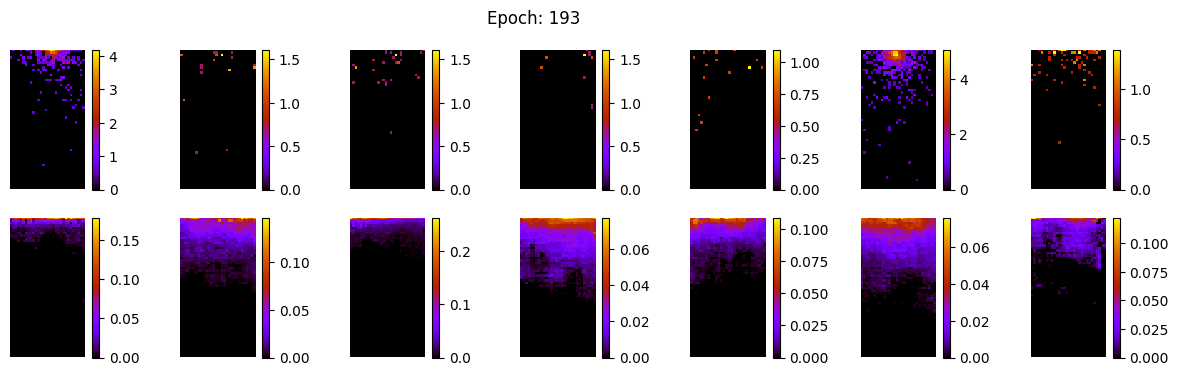

98/98 [==============================] - 0s 3ms/step
ws mean 19.34 ch1 17.77 ch2 29.19 ch3 0.84 ch4 0.84 ch5 48.07 Time for epoch 194 is 8.041758298873901 sec
19100 [Total loss: 31.23] [Recon_loss: 30.88] [KL loss: 0.49]
98/98 [==============================] - 0s 3ms/step
ws mean 17.51 ch1 16.95 ch2 25.55 ch3 0.80 ch4 0.83 ch5 43.43 Time for epoch 195 is 6.779032945632935 sec
19200 [Total loss: 41.43] [Recon_loss: 40.61] [KL loss: 1.18]
98/98 [==============================] - 0s 3ms/step
ws mean 17.53 ch1 16.20 ch2 26.19 ch3 0.77 ch4 0.79 ch5 43.70 Time for epoch 288 is 6.751297473907471 sec
28300 [Total loss: 36.06] [Recon_loss: 35.62] [KL loss: 0.64]
98/98 [==============================] - 0s 3ms/step
ws mean 17.43 ch1 16.36 ch2 25.79 ch3 0.79 ch4 0.81 ch5 43.39 Time for epoch 289 is 6.766215085983276 sec
28400 [Total loss: 36.52] [Recon_loss: 36.23] [KL loss: 0.41]
98/98 [==============================] - 0s 3ms/step
ws mean 18.10 ch1 16.42 ch2 26.88 ch3 0.90 ch4 0.90 ch5 45.42 T

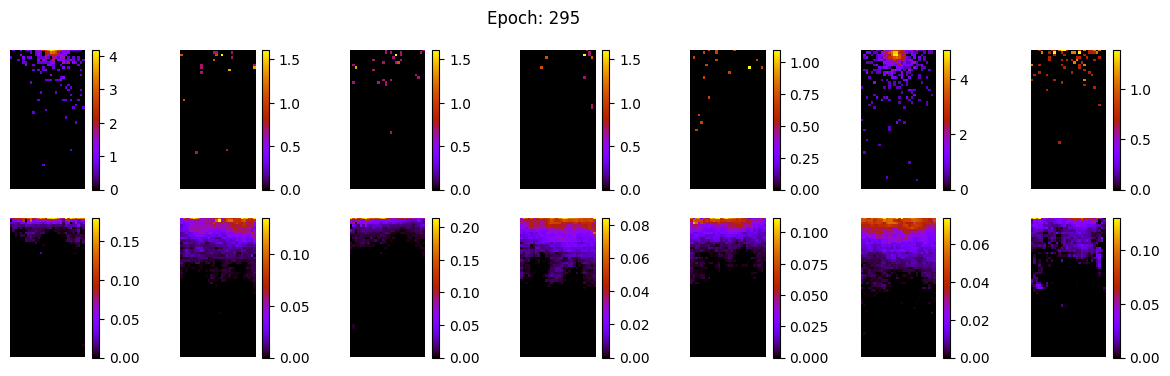

98/98 [==============================] - 0s 3ms/step
ws mean 16.47 ch1 14.92 ch2 24.83 ch3 0.76 ch4 0.78 ch5 41.04 Time for epoch 296 is 8.423166513442993 sec
29100 [Total loss: 40.15] [Recon_loss: 39.51] [KL loss: 0.92]
98/98 [==============================] - 0s 3ms/step
ws mean 14.23 ch1 14.01 ch2 20.81 ch3 0.64 ch4 0.66 ch5 35.02 Time for epoch 297 is 6.795795202255249 sec
29200 [Total loss: 37.26] [Recon_loss: 36.61] [KL loss: 0.92]
98/98 [==============================] - 0s 3ms/step
ws mean 19.63 ch1 18.16 ch2 29.21 ch3 0.78 ch4 0.82 ch5 49.16 Time for epoch 298 is 6.823518514633179 sec
29300 [Total loss: 37.34] [Recon_loss: 36.82] [KL loss: 0.75]
98/98 [==============================] - 0s 3ms/step
ws mean 16.39 ch1 15.63 ch2 24.39 ch3 0.74 ch4 0.74 ch5 40.44 Time for epoch 299 is 6.820152759552002 sec
29400 [Total loss: 35.52] [Recon_loss: 35.16] [KL loss: 0.52]
98/98 [==============================] - 0s 3ms/step
ws mean 19.63 ch1 17.08 ch2 30.28 ch3 0.75 ch4 0.75 ch5 49.29 T

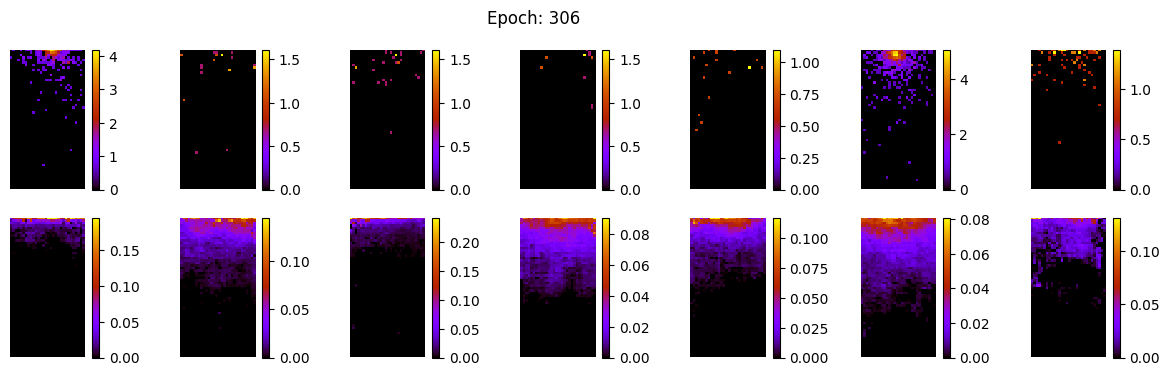

98/98 [==============================] - 0s 3ms/step
ws mean 18.10 ch1 16.45 ch2 27.02 ch3 0.83 ch4 0.86 ch5 45.35 Time for epoch 307 is 8.210211753845215 sec
30100 [Total loss: 32.27] [Recon_loss: 31.96] [KL loss: 0.45]
98/98 [==============================] - 0s 3ms/step
ws mean 20.22 ch1 18.00 ch2 30.73 ch3 0.82 ch4 0.84 ch5 50.69 Time for epoch 308 is 6.915584564208984 sec
30200 [Total loss: 35.85] [Recon_loss: 35.43] [KL loss: 0.59]
98/98 [==============================] - 0s 3ms/step
ws mean 18.94 ch1 17.15 ch2 28.33 ch3 0.80 ch4 0.83 ch5 47.58 Time for epoch 309 is 6.920659303665161 sec
30300 [Total loss: 36.78] [Recon_loss: 36.42] [KL loss: 0.51]
98/98 [==============================] - 0s 3ms/step
ws mean 19.70 ch1 17.72 ch2 29.63 ch3 0.81 ch4 0.84 ch5 49.50 Time for epoch 310 is 6.9505345821380615 sec
30400 [Total loss: 31.41] [Recon_loss: 31.05] [KL loss: 0.52]
98/98 [==============================] - 0s 3ms/step
ws mean 19.02 ch1 16.94 ch2 29.16 ch3 0.73 ch4 0.75 ch5 47.54 

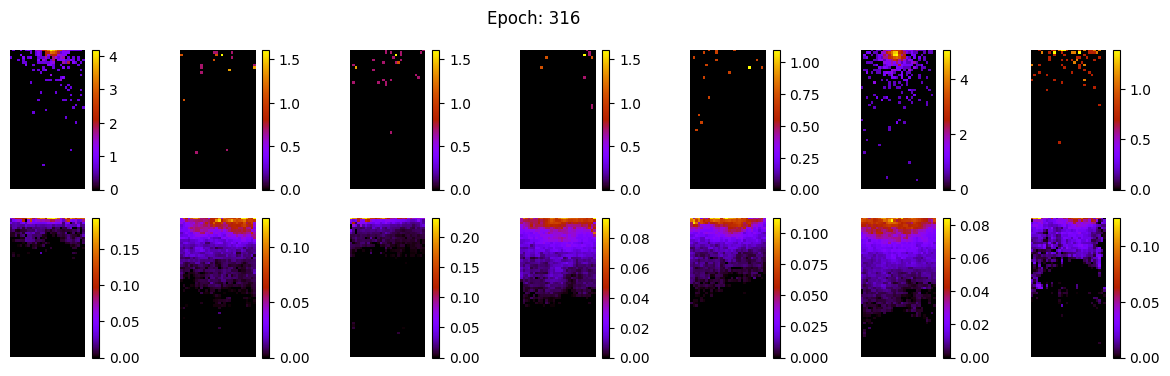

98/98 [==============================] - 0s 3ms/step
ws mean 16.89 ch1 15.82 ch2 25.13 ch3 0.78 ch4 0.79 ch5 41.93 Time for epoch 317 is 8.349303245544434 sec
31100 [Total loss: 36.56] [Recon_loss: 36.26] [KL loss: 0.42]
98/98 [==============================] - 0s 3ms/step
ws mean 20.73 ch1 18.29 ch2 31.92 ch3 0.77 ch4 0.82 ch5 51.86 Time for epoch 318 is 7.082793235778809 sec
31200 [Total loss: 37.69] [Recon_loss: 36.56] [KL loss: 1.62]
98/98 [==============================] - 0s 3ms/step
ws mean 18.92 ch1 17.09 ch2 28.71 ch3 0.71 ch4 0.71 ch5 47.37 Time for epoch 319 is 7.086766004562378 sec
31300 [Total loss: 42.96] [Recon_loss: 42.10] [KL loss: 1.23]
98/98 [==============================] - 0s 3ms/step
ws mean 18.18 ch1 16.89 ch2 27.25 ch3 0.79 ch4 0.81 ch5 45.17 Time for epoch 320 is 7.123546600341797 sec
31400 [Total loss: 40.41] [Recon_loss: 39.51] [KL loss: 1.28]
98/98 [==============================] - 0s 4ms/step
ws mean 15.76 ch1 15.08 ch2 22.92 ch3 0.73 ch4 0.75 ch5 39.32 T

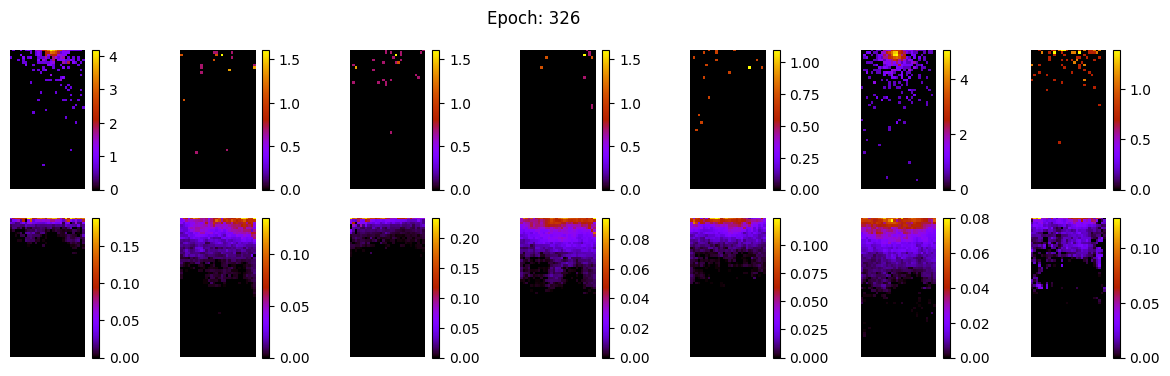

98/98 [==============================] - 0s 4ms/step
ws mean 19.92 ch1 18.05 ch2 30.12 ch3 0.78 ch4 0.79 ch5 49.84 Time for epoch 327 is 9.083715200424194 sec
32100 [Total loss: 36.70] [Recon_loss: 36.27] [KL loss: 0.61]
98/98 [==============================] - 0s 4ms/step
ws mean 17.65 ch1 16.18 ch2 26.14 ch3 0.85 ch4 0.88 ch5 44.20 Time for epoch 328 is 7.23695969581604 sec
32200 [Total loss: 40.59] [Recon_loss: 39.70] [KL loss: 1.27]
98/98 [==============================] - 0s 4ms/step
ws mean 19.60 ch1 17.38 ch2 29.94 ch3 0.78 ch4 0.80 ch5 49.07 Time for epoch 329 is 7.258433103561401 sec
32300 [Total loss: 37.99] [Recon_loss: 37.61] [KL loss: 0.54]
98/98 [==============================] - 0s 4ms/step
ws mean 16.89 ch1 15.74 ch2 24.87 ch3 0.89 ch4 0.90 ch5 42.04 Time for epoch 330 is 7.243227958679199 sec
32400 [Total loss: 32.99] [Recon_loss: 32.50] [KL loss: 0.71]
98/98 [==============================] - 0s 4ms/step
ws mean 16.92 ch1 15.96 ch2 24.96 ch3 0.81 ch4 0.83 ch5 42.04 Ti

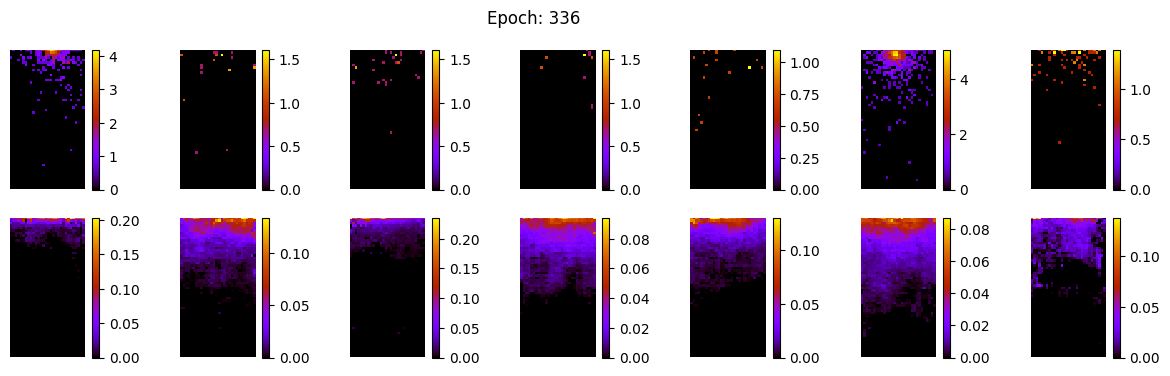

98/98 [==============================] - 0s 4ms/step
ws mean 18.45 ch1 16.47 ch2 27.90 ch3 0.80 ch4 0.83 ch5 46.24 Time for epoch 337 is 8.564698457717896 sec
33100 [Total loss: 31.50] [Recon_loss: 31.22] [KL loss: 0.40]
98/98 [==============================] - 0s 4ms/step
ws mean 18.40 ch1 16.62 ch2 27.56 ch3 0.85 ch4 0.85 ch5 46.11 Time for epoch 338 is 7.2469518184661865 sec
33200 [Total loss: 34.71] [Recon_loss: 34.41] [KL loss: 0.42]
98/98 [==============================] - 0s 4ms/step
ws mean 21.43 ch1 19.05 ch2 32.19 ch3 0.98 ch4 0.99 ch5 53.96 Time for epoch 339 is 7.245819807052612 sec
33300 [Total loss: 37.01] [Recon_loss: 36.53] [KL loss: 0.69]
98/98 [==============================] - 0s 4ms/step
ws mean 19.61 ch1 17.95 ch2 29.27 ch3 0.81 ch4 0.85 ch5 49.19 Time for epoch 340 is 7.235435962677002 sec
33400 [Total loss: 33.43] [Recon_loss: 33.12] [KL loss: 0.45]
98/98 [==============================] - 0s 4ms/step
ws mean 20.05 ch1 18.48 ch2 29.68 ch3 0.85 ch4 0.86 ch5 50.38 

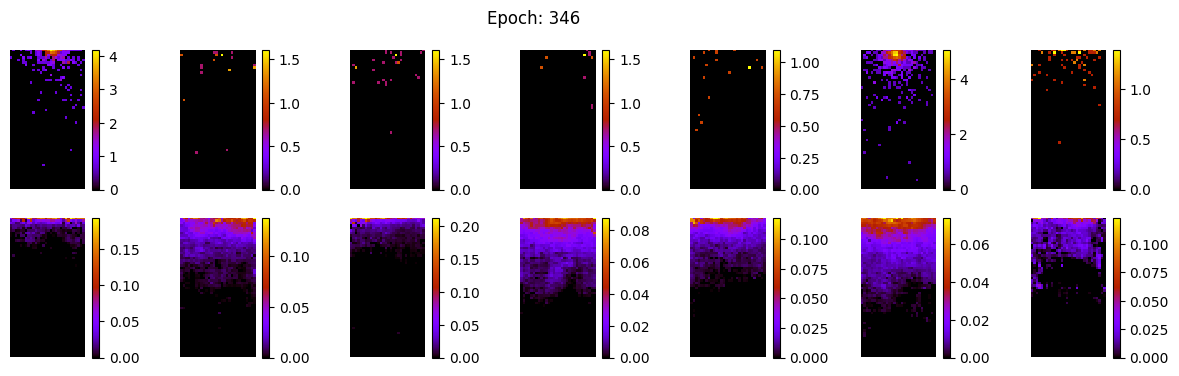

98/98 [==============================] - 0s 4ms/step
ws mean 18.39 ch1 16.43 ch2 28.33 ch3 0.76 ch4 0.78 ch5 45.64 Time for epoch 347 is 8.908651113510132 sec
34100 [Total loss: 38.13] [Recon_loss: 37.82] [KL loss: 0.44]
98/98 [==============================] - 0s 4ms/step
ws mean 18.75 ch1 17.64 ch2 27.63 ch3 0.74 ch4 0.78 ch5 46.97 Time for epoch 348 is 7.271471738815308 sec
34200 [Total loss: 38.67] [Recon_loss: 38.15] [KL loss: 0.75]
98/98 [==============================] - 0s 4ms/step
ws mean 21.67 ch1 19.20 ch2 32.81 ch3 0.92 ch4 0.93 ch5 54.47 Time for epoch 349 is 7.269569158554077 sec
34300 [Total loss: 35.36] [Recon_loss: 34.94] [KL loss: 0.60]
98/98 [==============================] - 0s 4ms/step
ws mean 18.12 ch1 16.49 ch2 26.93 ch3 0.85 ch4 0.87 ch5 45.49 Time for epoch 350 is 7.251766204833984 sec
98/98 [==============================] - 0s 4ms/step
ws mean 19.63 ch1 17.94 ch2 29.19 ch3 0.87 ch4 0.88 ch5 49.27 Time for epoch 351 is 7.253819942474365 sec
34400 [Total loss: 

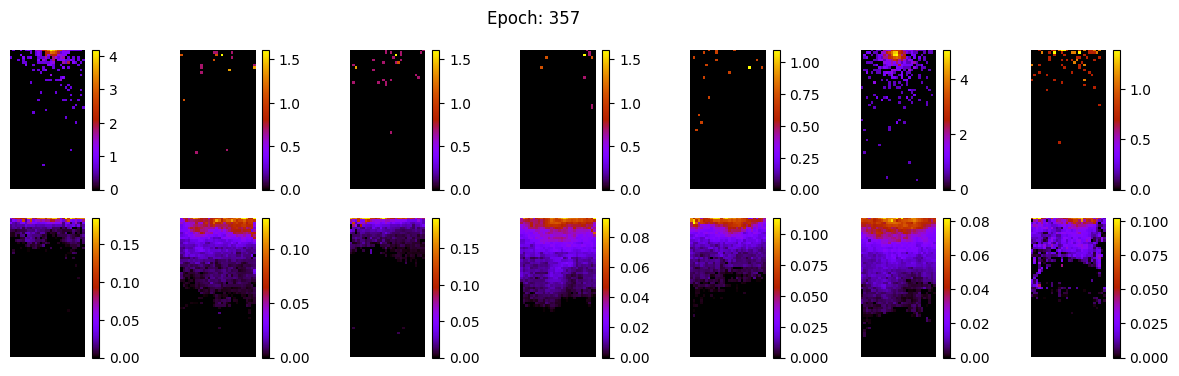

98/98 [==============================] - 0s 3ms/step
ws mean 19.31 ch1 17.10 ch2 29.61 ch3 0.73 ch4 0.78 ch5 48.35 Time for epoch 358 is 8.48337984085083 sec
35100 [Total loss: 36.08] [Recon_loss: 35.73] [KL loss: 0.51]
98/98 [==============================] - 0s 3ms/step
ws mean 17.53 ch1 15.64 ch2 26.70 ch3 0.73 ch4 0.74 ch5 43.82 Time for epoch 359 is 7.17334508895874 sec
35200 [Total loss: 34.74] [Recon_loss: 34.45] [KL loss: 0.42]
98/98 [==============================] - 0s 4ms/step
ws mean 15.97 ch1 15.44 ch2 23.34 ch3 0.75 ch4 0.77 ch5 39.54 Time for epoch 360 is 7.172865867614746 sec
35300 [Total loss: 32.84] [Recon_loss: 32.40] [KL loss: 0.63]
98/98 [==============================] - 0s 4ms/step
ws mean 17.44 ch1 15.74 ch2 26.55 ch3 0.78 ch4 0.79 ch5 43.34 Time for epoch 361 is 7.208415508270264 sec
35400 [Total loss: 33.20] [Recon_loss: 32.88] [KL loss: 0.46]
98/98 [==============================] - 0s 4ms/step
ws mean 18.38 ch1 16.69 ch2 27.60 ch3 0.77 ch4 0.77 ch5 46.07 Tim

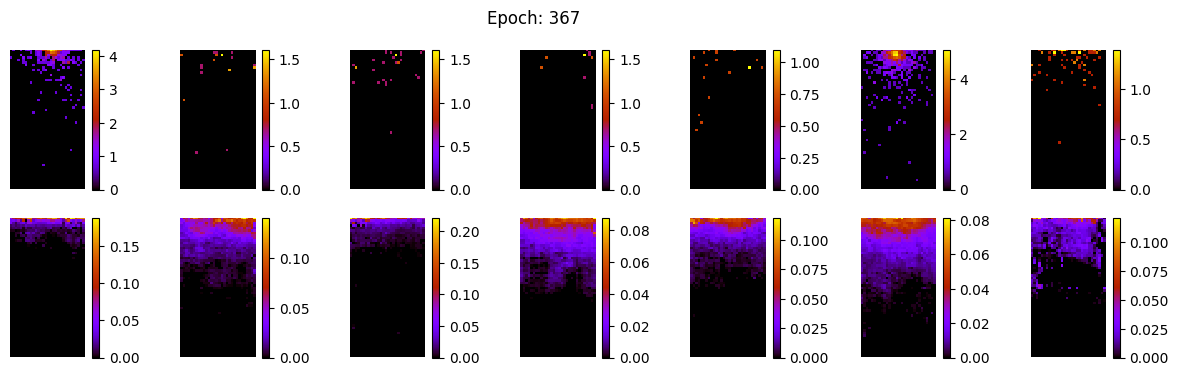

98/98 [==============================] - 0s 4ms/step
ws mean 13.08 ch1 12.75 ch2 19.33 ch3 0.73 ch4 0.75 ch5 31.83 Time for epoch 368 is 8.542783260345459 sec
36100 [Total loss: 35.95] [Recon_loss: 35.49] [KL loss: 0.65]
98/98 [==============================] - 0s 4ms/step
ws mean 15.76 ch1 14.70 ch2 23.40 ch3 0.73 ch4 0.75 ch5 39.22 Time for epoch 369 is 7.235641956329346 sec
36200 [Total loss: 32.55] [Recon_loss: 32.25] [KL loss: 0.44]
98/98 [==============================] - 0s 4ms/step
ws mean 18.08 ch1 16.37 ch2 27.11 ch3 0.90 ch4 0.91 ch5 45.14 Time for epoch 370 is 7.272256851196289 sec
36300 [Total loss: 38.20] [Recon_loss: 37.72] [KL loss: 0.68]
98/98 [==============================] - 0s 4ms/step
ws mean 14.12 ch1 13.52 ch2 20.97 ch3 0.65 ch4 0.68 ch5 34.78 Time for epoch 371 is 7.281901597976685 sec
36400 [Total loss: 36.95] [Recon_loss: 36.20] [KL loss: 1.07]
98/98 [==============================] - 0s 4ms/step
ws mean 17.09 ch1 15.56 ch2 25.38 ch3 0.77 ch4 0.80 ch5 42.93 T

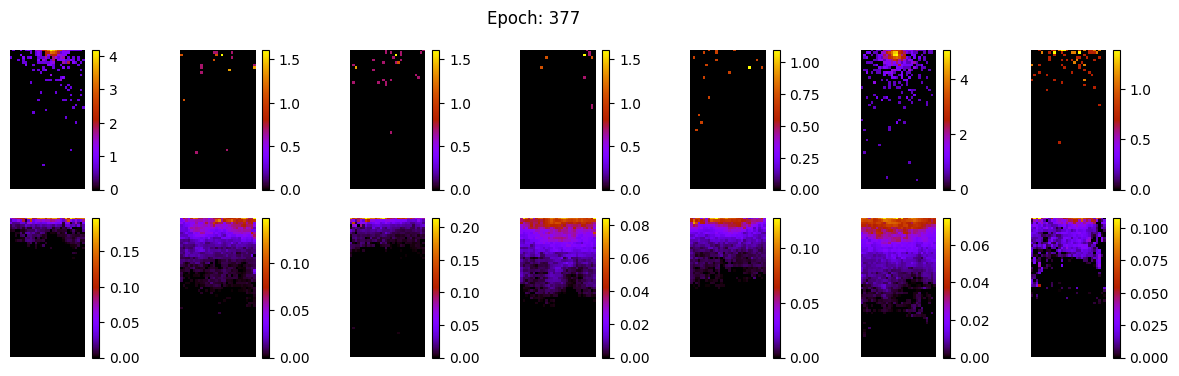

98/98 [==============================] - 0s 3ms/step
ws mean 18.82 ch1 17.33 ch2 27.76 ch3 0.87 ch4 0.90 ch5 47.24 Time for epoch 378 is 8.423081636428833 sec
37100 [Total loss: 27.96] [Recon_loss: 27.75] [KL loss: 0.31]
98/98 [==============================] - 0s 4ms/step
ws mean 17.89 ch1 15.99 ch2 26.85 ch3 0.83 ch4 0.86 ch5 44.91 Time for epoch 379 is 7.195230007171631 sec
37200 [Total loss: 31.87] [Recon_loss: 31.60] [KL loss: 0.39]
98/98 [==============================] - 0s 4ms/step
ws mean 17.07 ch1 15.50 ch2 25.56 ch3 0.75 ch4 0.79 ch5 42.73 Time for epoch 380 is 7.159426689147949 sec
37300 [Total loss: 32.64] [Recon_loss: 32.30] [KL loss: 0.49]
98/98 [==============================] - 0s 4ms/step
ws mean 18.79 ch1 16.54 ch2 28.68 ch3 0.79 ch4 0.81 ch5 47.14 Time for epoch 381 is 7.190378904342651 sec
37400 [Total loss: 40.03] [Recon_loss: 39.46] [KL loss: 0.82]
98/98 [==============================] - 0s 4ms/step
ws mean 19.31 ch1 16.92 ch2 29.76 ch3 0.73 ch4 0.78 ch5 48.36 T

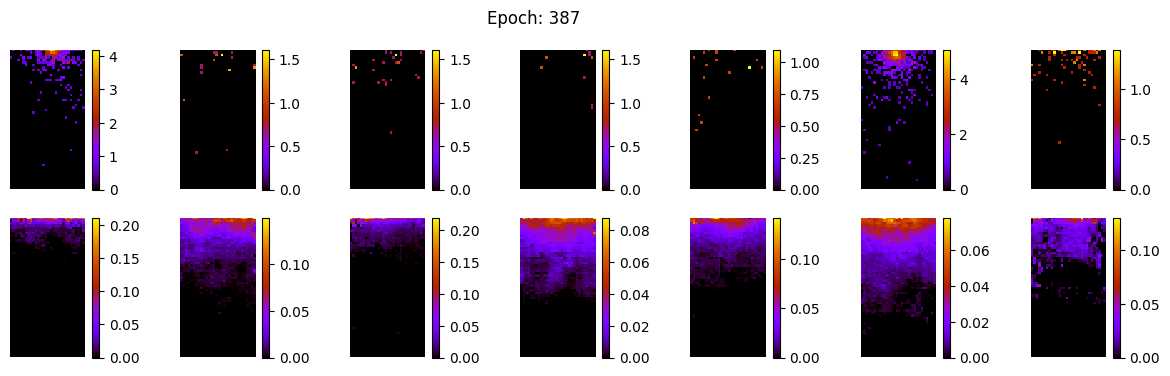

98/98 [==============================] - 0s 4ms/step
ws mean 16.11 ch1 15.05 ch2 23.94 ch3 0.75 ch4 0.79 ch5 40.00 Time for epoch 388 is 8.548920392990112 sec
38100 [Total loss: 35.58] [Recon_loss: 35.24] [KL loss: 0.49]
98/98 [==============================] - 0s 4ms/step
ws mean 17.28 ch1 16.03 ch2 25.40 ch3 0.85 ch4 0.90 ch5 43.22 Time for epoch 389 is 7.237645864486694 sec
38200 [Total loss: 34.45] [Recon_loss: 34.07] [KL loss: 0.55]
98/98 [==============================] - 0s 3ms/step
ws mean 17.23 ch1 15.97 ch2 25.41 ch3 0.87 ch4 0.90 ch5 42.99 Time for epoch 390 is 7.2090840339660645 sec
38300 [Total loss: 33.27] [Recon_loss: 32.94] [KL loss: 0.46]
98/98 [==============================] - 0s 4ms/step
ws mean 18.47 ch1 16.72 ch2 27.72 ch3 0.79 ch4 0.81 ch5 46.32 Time for epoch 391 is 7.210165977478027 sec
38400 [Total loss: 33.82] [Recon_loss: 33.40] [KL loss: 0.59]
98/98 [==============================] - 0s 4ms/step
ws mean 18.48 ch1 16.87 ch2 27.51 ch3 0.81 ch4 0.84 ch5 46.35 

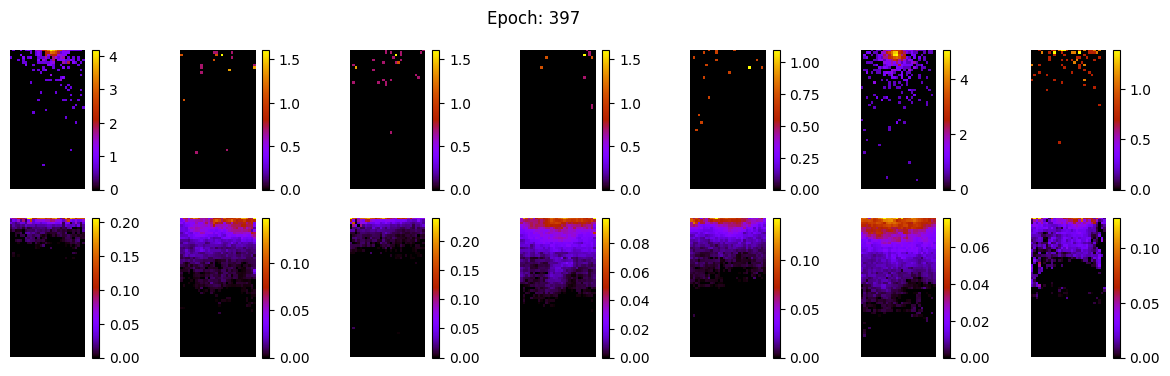

98/98 [==============================] - 0s 4ms/step
ws mean 15.19 ch1 14.59 ch2 22.46 ch3 0.73 ch4 0.75 ch5 37.44 Time for epoch 398 is 8.908052921295166 sec
39100 [Total loss: 38.55] [Recon_loss: 38.00] [KL loss: 0.79]
98/98 [==============================] - 0s 4ms/step
ws mean 17.77 ch1 16.26 ch2 26.40 ch3 0.82 ch4 0.83 ch5 44.54 Time for epoch 399 is 7.233834266662598 sec
39200 [Total loss: 31.00] [Recon_loss: 30.72] [KL loss: 0.41]
98/98 [==============================] - 0s 4ms/step
ws mean 18.37 ch1 16.87 ch2 26.96 ch3 0.94 ch4 0.96 ch5 46.10 Time for epoch 400 is 7.232656955718994 sec
98/98 [==============================] - 0s 4ms/step
ws mean 19.29 ch1 17.17 ch2 29.32 ch3 0.83 ch4 0.86 ch5 48.26 Time for epoch 401 is 7.2322163581848145 sec
39300 [Total loss: 31.32] [Recon_loss: 30.98] [KL loss: 0.48]
98/98 [==============================] - 0s 4ms/step
ws mean 15.44 ch1 15.14 ch2 22.46 ch3 0.72 ch4 0.74 ch5 38.15 Time for epoch 402 is 7.241205930709839 sec
39400 [Total loss:

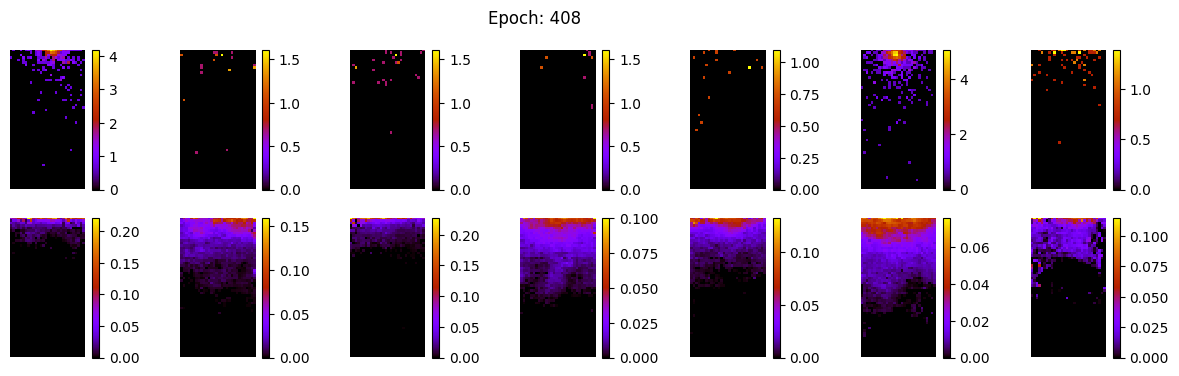

98/98 [==============================] - 0s 4ms/step
ws mean 16.17 ch1 15.61 ch2 23.39 ch3 0.73 ch4 0.78 ch5 40.34 Time for epoch 409 is 8.505046606063843 sec
40100 [Total loss: 34.35] [Recon_loss: 34.02] [KL loss: 0.48]
98/98 [==============================] - 0s 4ms/step
ws mean 17.50 ch1 16.10 ch2 26.05 ch3 0.80 ch4 0.82 ch5 43.71 Time for epoch 410 is 7.190356016159058 sec
40200 [Total loss: 32.91] [Recon_loss: 32.39] [KL loss: 0.74]
98/98 [==============================] - 0s 3ms/step
ws mean 18.75 ch1 17.19 ch2 27.89 ch3 0.86 ch4 0.88 ch5 46.92 Time for epoch 411 is 7.207312107086182 sec
40300 [Total loss: 35.85] [Recon_loss: 34.49] [KL loss: 1.94]
98/98 [==============================] - 0s 4ms/step
ws mean 16.19 ch1 15.63 ch2 23.84 ch3 0.76 ch4 0.79 ch5 39.96 Time for epoch 412 is 7.211825132369995 sec
40400 [Total loss: 37.87] [Recon_loss: 37.46] [KL loss: 0.58]
98/98 [==============================] - 0s 4ms/step
ws mean 18.36 ch1 17.07 ch2 26.90 ch3 0.92 ch4 0.96 ch5 45.93 T

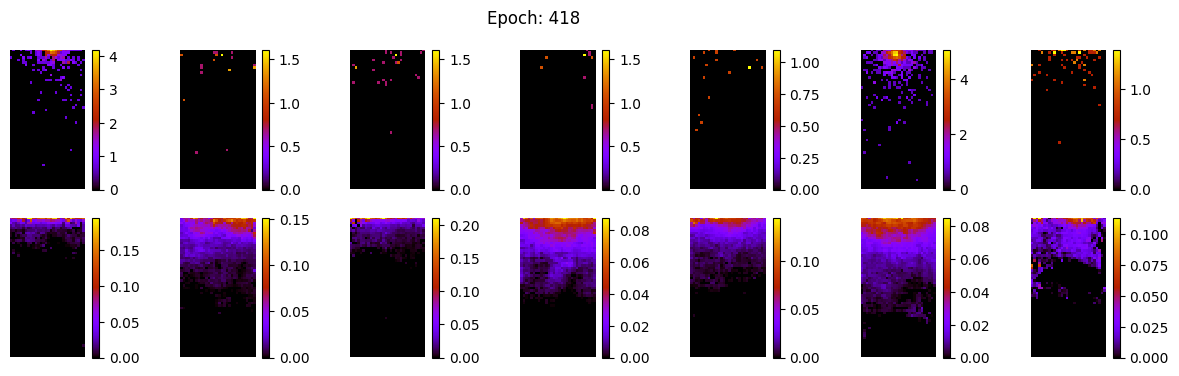

98/98 [==============================] - 0s 4ms/step
ws mean 17.78 ch1 16.49 ch2 26.29 ch3 0.79 ch4 0.83 ch5 44.51 Time for epoch 419 is 9.044681310653687 sec
41100 [Total loss: 31.58] [Recon_loss: 31.09] [KL loss: 0.71]
98/98 [==============================] - 0s 4ms/step
ws mean 16.64 ch1 15.53 ch2 24.86 ch3 0.69 ch4 0.72 ch5 41.40 Time for epoch 420 is 7.23292088508606 sec
41200 [Total loss: 38.45] [Recon_loss: 37.35] [KL loss: 1.58]
98/98 [==============================] - 0s 4ms/step
ws mean 16.55 ch1 15.39 ch2 24.71 ch3 0.74 ch4 0.78 ch5 41.14 Time for epoch 421 is 7.228378772735596 sec
41300 [Total loss: 35.95] [Recon_loss: 35.46] [KL loss: 0.70]
98/98 [==============================] - 0s 4ms/step
ws mean 17.17 ch1 16.26 ch2 25.39 ch3 0.72 ch4 0.77 ch5 42.72 Time for epoch 422 is 7.2051780223846436 sec
41400 [Total loss: 29.43] [Recon_loss: 28.99] [KL loss: 0.62]
98/98 [==============================] - 0s 4ms/step
ws mean 15.31 ch1 14.71 ch2 22.42 ch3 0.74 ch4 0.76 ch5 37.95 T

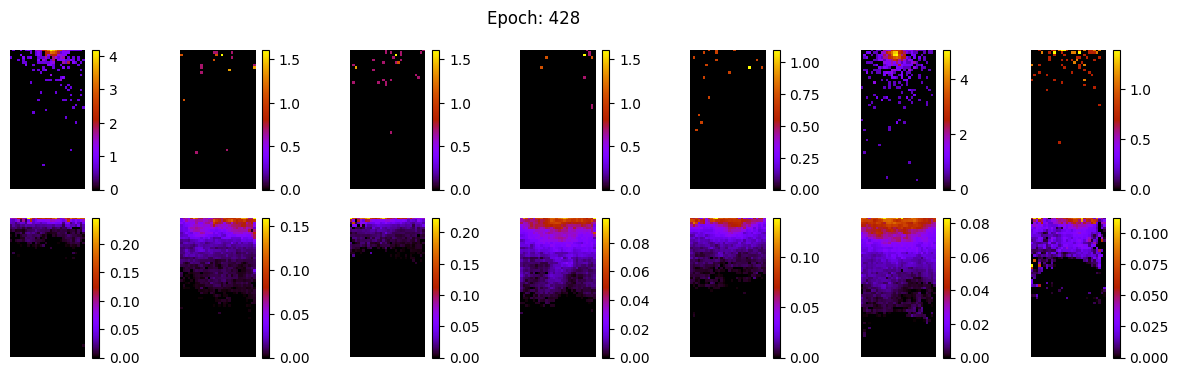

98/98 [==============================] - 0s 4ms/step
ws mean 18.90 ch1 17.08 ch2 28.24 ch3 0.88 ch4 0.88 ch5 47.43 Time for epoch 429 is 8.49092960357666 sec
42100 [Total loss: 35.72] [Recon_loss: 35.14] [KL loss: 0.82]
98/98 [==============================] - 0s 4ms/step
ws mean 17.59 ch1 16.21 ch2 25.86 ch3 0.91 ch4 0.93 ch5 44.01 Time for epoch 430 is 7.21312952041626 sec
42200 [Total loss: 31.22] [Recon_loss: 30.84] [KL loss: 0.54]
98/98 [==============================] - 0s 4ms/step
ws mean 15.84 ch1 15.15 ch2 22.94 ch3 0.85 ch4 0.88 ch5 39.35 Time for epoch 431 is 7.227173089981079 sec
42300 [Total loss: 34.90] [Recon_loss: 34.37] [KL loss: 0.76]
98/98 [==============================] - 0s 4ms/step
ws mean 16.61 ch1 15.11 ch2 24.46 ch3 0.89 ch4 0.90 ch5 41.67 Time for epoch 432 is 7.247052431106567 sec
42400 [Total loss: 41.01] [Recon_loss: 39.92] [KL loss: 1.55]
98/98 [==============================] - 0s 4ms/step
ws mean 18.84 ch1 17.05 ch2 28.26 ch3 0.82 ch4 0.85 ch5 47.24 Tim

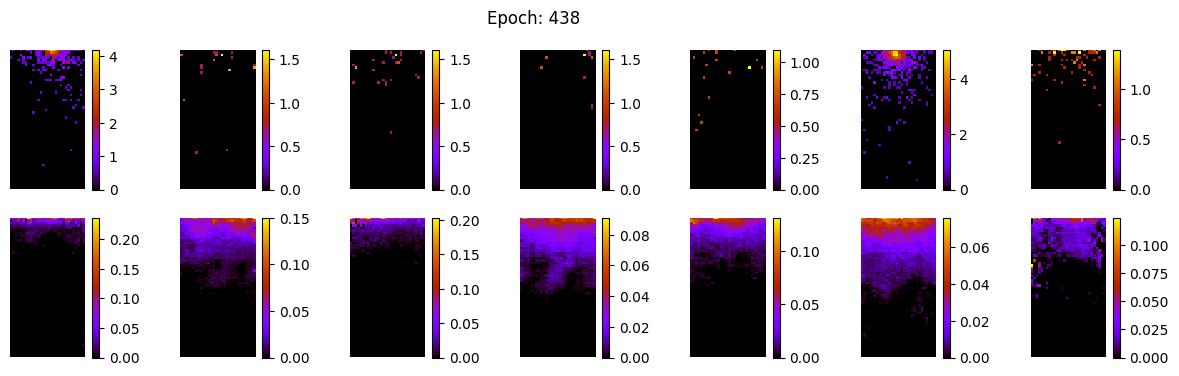

98/98 [==============================] - 0s 4ms/step
ws mean 18.26 ch1 16.48 ch2 27.41 ch3 0.81 ch4 0.86 ch5 45.73 Time for epoch 439 is 8.53272795677185 sec
43100 [Total loss: 39.74] [Recon_loss: 39.02] [KL loss: 1.03]
98/98 [==============================] - 0s 4ms/step
ws mean 16.50 ch1 15.66 ch2 24.10 ch3 0.83 ch4 0.85 ch5 41.03 Time for epoch 440 is 7.22904372215271 sec
43200 [Total loss: 33.14] [Recon_loss: 32.49] [KL loss: 0.93]
98/98 [==============================] - 0s 4ms/step
ws mean 17.10 ch1 16.09 ch2 25.16 ch3 0.73 ch4 0.78 ch5 42.74 Time for epoch 441 is 7.221312761306763 sec
43300 [Total loss: 36.38] [Recon_loss: 35.92] [KL loss: 0.65]
98/98 [==============================] - 0s 4ms/step
ws mean 16.06 ch1 15.22 ch2 23.32 ch3 0.89 ch4 0.92 ch5 39.94 Time for epoch 442 is 7.200705051422119 sec
43400 [Total loss: 32.07] [Recon_loss: 31.69] [KL loss: 0.54]
98/98 [==============================] - 0s 4ms/step
ws mean 16.08 ch1 15.58 ch2 23.31 ch3 0.83 ch4 0.86 ch5 39.82 Tim

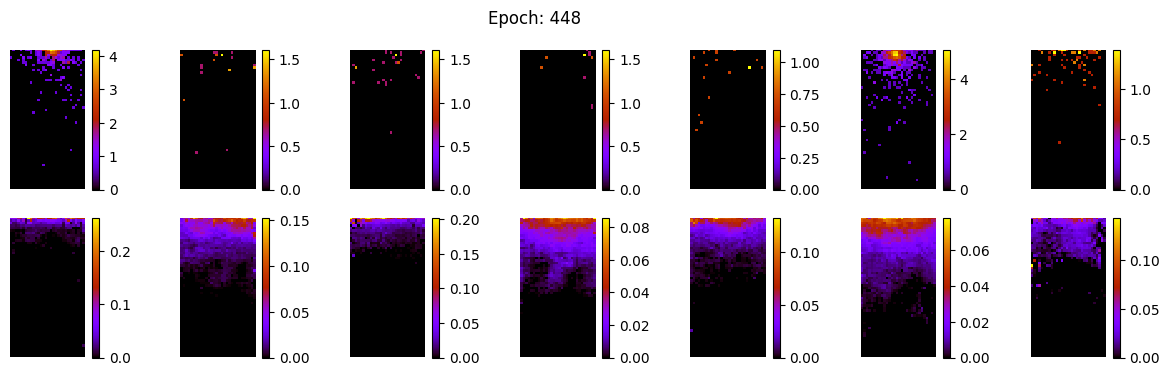

98/98 [==============================] - 0s 4ms/step
ws mean 17.83 ch1 15.64 ch2 27.07 ch3 0.84 ch4 0.86 ch5 44.75 Time for epoch 449 is 8.900741577148438 sec
44100 [Total loss: 35.98] [Recon_loss: 35.55] [KL loss: 0.61]
98/98 [==============================] - 0s 4ms/step
ws mean 18.52 ch1 17.28 ch2 27.42 ch3 0.83 ch4 0.87 ch5 46.22 Time for epoch 450 is 7.234861612319946 sec
98/98 [==============================] - 0s 4ms/step
ws mean 13.98 ch1 13.94 ch2 20.15 ch3 0.73 ch4 0.79 ch5 34.29 Time for epoch 451 is 7.225223541259766 sec
44200 [Total loss: 40.35] [Recon_loss: 39.40] [KL loss: 1.35]
98/98 [==============================] - 0s 4ms/step
ws mean 22.10 ch1 19.47 ch2 33.71 ch3 0.93 ch4 0.96 ch5 55.44 Time for epoch 452 is 7.24363899230957 sec
44300 [Total loss: 36.54] [Recon_loss: 35.94] [KL loss: 0.86]
98/98 [==============================] - 0s 4ms/step
ws mean 19.30 ch1 17.42 ch2 28.96 ch3 0.85 ch4 0.88 ch5 48.38 Time for epoch 453 is 7.233471393585205 sec
44400 [Total loss: 3

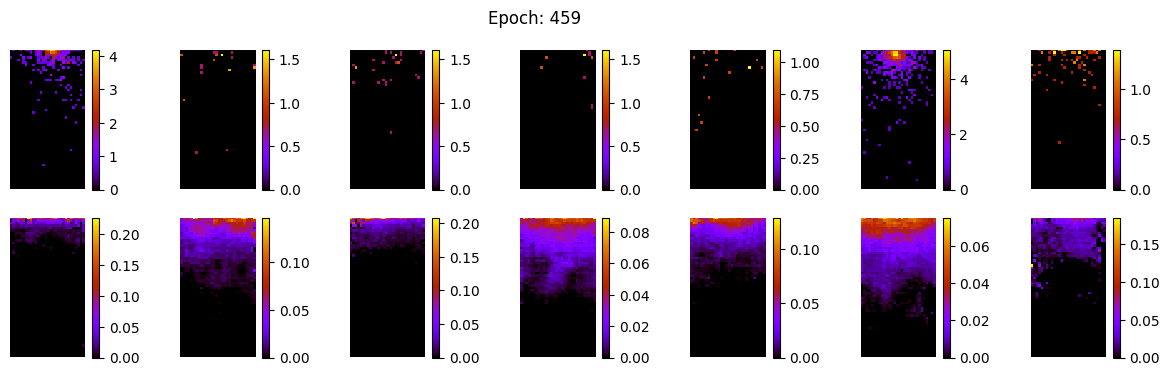

98/98 [==============================] - 0s 4ms/step
ws mean 15.02 ch1 14.30 ch2 21.91 ch3 0.82 ch4 0.88 ch5 37.21 Time for epoch 460 is 8.544605493545532 sec
45100 [Total loss: 35.44] [Recon_loss: 34.90] [KL loss: 0.78]
98/98 [==============================] - 0s 4ms/step
ws mean 18.77 ch1 17.59 ch2 27.31 ch3 0.94 ch4 0.98 ch5 47.01 Time for epoch 461 is 7.254364728927612 sec
45200 [Total loss: 35.08] [Recon_loss: 34.48] [KL loss: 0.87]
98/98 [==============================] - 0s 4ms/step
ws mean 19.75 ch1 17.72 ch2 29.47 ch3 0.94 ch4 0.97 ch5 49.64 Time for epoch 462 is 7.232521057128906 sec
45300 [Total loss: 38.03] [Recon_loss: 37.64] [KL loss: 0.56]
98/98 [==============================] - 0s 4ms/step
ws mean 18.13 ch1 16.36 ch2 27.26 ch3 0.80 ch4 0.85 ch5 45.38 Time for epoch 463 is 7.2666685581207275 sec
45400 [Total loss: 36.07] [Recon_loss: 35.53] [KL loss: 0.78]
98/98 [==============================] - 0s 4ms/step
ws mean 17.97 ch1 16.61 ch2 26.49 ch3 0.89 ch4 0.92 ch5 44.95 

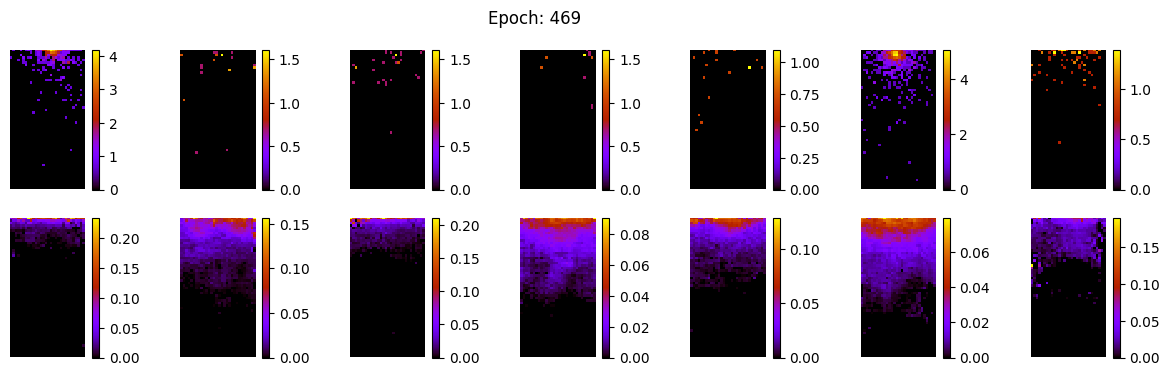

98/98 [==============================] - 0s 4ms/step
ws mean 16.11 ch1 15.24 ch2 23.60 ch3 0.80 ch4 0.82 ch5 40.10 Time for epoch 470 is 9.006596803665161 sec
46100 [Total loss: 34.28] [Recon_loss: 33.83] [KL loss: 0.64]
98/98 [==============================] - 0s 4ms/step
ws mean 14.84 ch1 14.19 ch2 21.58 ch3 0.84 ch4 0.89 ch5 36.70 Time for epoch 471 is 7.268054485321045 sec
46200 [Total loss: 36.82] [Recon_loss: 36.30] [KL loss: 0.74]
98/98 [==============================] - 0s 4ms/step
ws mean 17.84 ch1 16.16 ch2 27.12 ch3 0.67 ch4 0.74 ch5 44.50 Time for epoch 472 is 7.235925197601318 sec
46300 [Total loss: 27.83] [Recon_loss: 27.59] [KL loss: 0.33]
98/98 [==============================] - 0s 4ms/step
ws mean 17.49 ch1 16.30 ch2 25.78 ch3 0.84 ch4 0.89 ch5 43.63 Time for epoch 473 is 7.213887691497803 sec
46400 [Total loss: 41.34] [Recon_loss: 40.18] [KL loss: 1.66]
98/98 [==============================] - 0s 4ms/step
ws mean 17.30 ch1 15.93 ch2 25.35 ch3 0.90 ch4 0.93 ch5 43.39 T

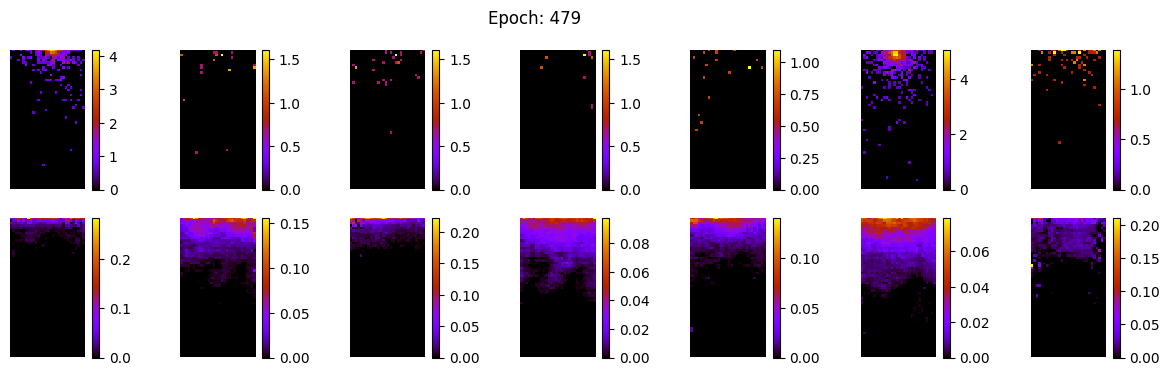

98/98 [==============================] - 0s 4ms/step
ws mean 18.08 ch1 16.51 ch2 26.75 ch3 0.87 ch4 0.93 ch5 45.32 Time for epoch 480 is 8.432079553604126 sec
47100 [Total loss: 34.11] [Recon_loss: 33.74] [KL loss: 0.53]
98/98 [==============================] - 0s 4ms/step
ws mean 18.87 ch1 16.72 ch2 28.81 ch3 0.79 ch4 0.84 ch5 47.15 Time for epoch 481 is 7.267157554626465 sec
47200 [Total loss: 34.22] [Recon_loss: 33.79] [KL loss: 0.62]
98/98 [==============================] - 0s 4ms/step
ws mean 18.24 ch1 16.00 ch2 27.95 ch3 0.78 ch4 0.83 ch5 45.64 Time for epoch 482 is 7.244382619857788 sec
47300 [Total loss: 36.10] [Recon_loss: 35.67] [KL loss: 0.62]
98/98 [==============================] - 0s 4ms/step
ws mean 17.78 ch1 16.36 ch2 26.45 ch3 0.85 ch4 0.88 ch5 44.37 Time for epoch 483 is 7.266082286834717 sec
47400 [Total loss: 34.63] [Recon_loss: 34.11] [KL loss: 0.74]
98/98 [==============================] - 0s 4ms/step
ws mean 16.47 ch1 15.20 ch2 24.35 ch3 0.87 ch4 0.90 ch5 41.05 T

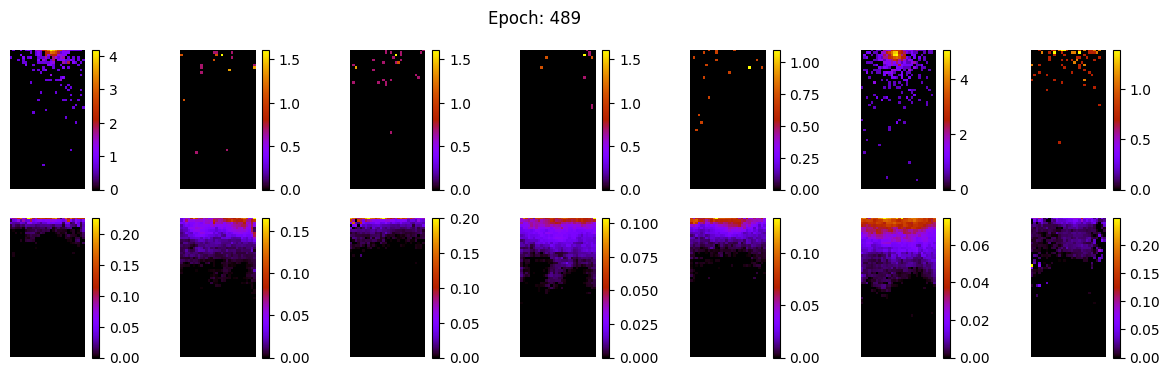

98/98 [==============================] - 0s 4ms/step
ws mean 15.24 ch1 14.00 ch2 22.92 ch3 0.70 ch4 0.77 ch5 37.80 Time for epoch 490 is 8.603135585784912 sec
48100 [Total loss: 33.48] [Recon_loss: 32.90] [KL loss: 0.83]
98/98 [==============================] - 0s 4ms/step
ws mean 17.68 ch1 16.30 ch2 26.55 ch3 0.67 ch4 0.74 ch5 44.14 Time for epoch 491 is 7.353124141693115 sec
48200 [Total loss: 39.54] [Recon_loss: 38.83] [KL loss: 1.01]
98/98 [==============================] - 0s 4ms/step
ws mean 17.05 ch1 16.13 ch2 25.11 ch3 0.70 ch4 0.76 ch5 42.53 Time for epoch 492 is 7.370579242706299 sec
48300 [Total loss: 35.14] [Recon_loss: 34.62] [KL loss: 0.74]
98/98 [==============================] - 0s 4ms/step
ws mean 19.24 ch1 17.24 ch2 29.36 ch3 0.69 ch4 0.75 ch5 48.16 Time for epoch 493 is 7.3642072677612305 sec
48400 [Total loss: 34.92] [Recon_loss: 34.53] [KL loss: 0.56]
98/98 [==============================] - 0s 4ms/step
ws mean 19.15 ch1 16.76 ch2 29.32 ch3 0.85 ch4 0.88 ch5 47.92 

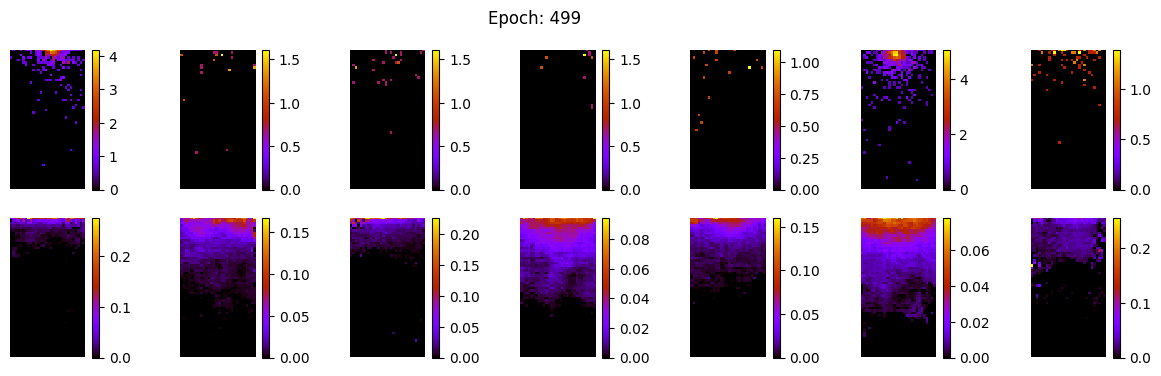

98/98 [==============================] - 0s 4ms/step
ws mean 15.23 ch1 14.52 ch2 22.76 ch3 0.66 ch4 0.71 ch5 37.52 Time for epoch 500 is 9.150047540664673 sec


In [ ]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = 0.7 * kl_loss + reconstruction_loss
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss


history = []
history_loss = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        # generate_and_save_images(generator,
        #                          epoch + 1,
        #                          [seed, seed_cond]
        #                          )

        # # Save the model every epoch
        # encoder.save_weights("../models/enc_"+NAME + "_"+ str(epoch) +".h5")
        # generator.save_weights("../models/gen_"+NAME + "_"+ str(epoch) +".h5")
        # np.savez("../models/history_"+NAME+".npz",np.array(history))
        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15,4))
    fig.suptitle(f"Epoch: {epoch}")
    for i in range(0,14):
        if i <7:
            x = x_test[20+i].reshape(56,30)
        else:
            x = predictions[i-7].numpy().reshape(56,30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i//7,i%7].imshow(x,interpolation='none', cmap='gnuplot')
        axs[i//7,i%7].axis('off')
        fig.colorbar(im, ax=axs[i//7,i%7])
    plt.savefig('../images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# ### Train model
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [104]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [105]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [106]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [112]:
a4_dims = (14, 5)

def print_loss(loss_values, loss_str):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")

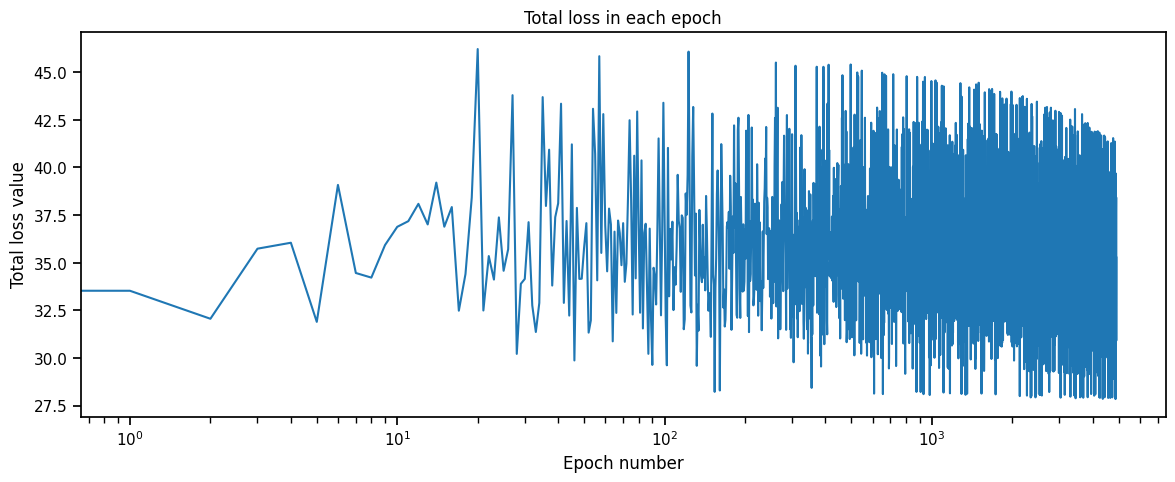

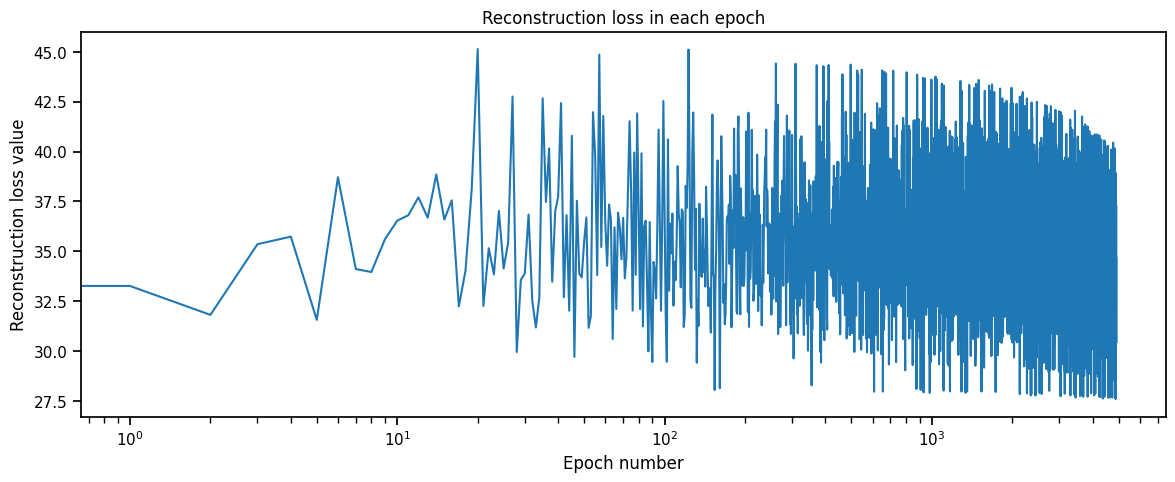

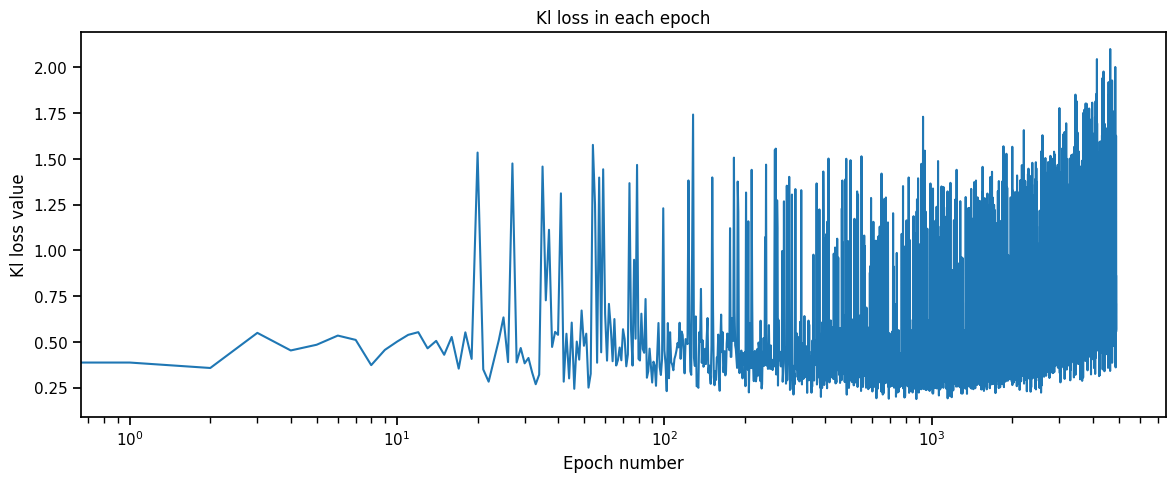

In [113]:
print_loss(total_loss[::10], "Total")
print_loss(reconstruction_loss[::10], "Reconstruction")
print_loss(kl_loss[::10], "Kl")